### List datasets that will be used for training with scBasset

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
cd ~/workspace/theislab/mubind-pipeline/notebooks/pipeline/01_train_n_predict/

/home/ilibarra/workspace/theislab/mubind-pipeline/notebooks/pipeline/01_train_n_predict


In [5]:
cd ..

/home/ilibarra/workspace/theislab/mubind-pipeline/notebooks/pipeline


/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [6]:
import mubind as mb
import utils

In [7]:
cd 01_train_n_predict/

/home/ilibarra/workspace/theislab/mubind-pipeline/notebooks/pipeline/01_train_n_predict


In [8]:
path_by_dataset = utils.get_datasets()
for k in path_by_dataset:
    print(k)
    if k != 'pancreatic_endocrinogenesis':
        continue

organoids
gbm
noack_2022
pancreatic_endocrinogenesis
pbmc


In [9]:
import torch

# data_directory = '/mnt/f/workspace/theislab/mubind/data'
data_directory = '/home/ilibarra/workspace/theislab/mubind/data'

path_by_dataset = utils.get_datasets(data_directory=data_directory)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


move to relevant directory to execute scbasset

In [10]:
import scanpy as sc
# only focus on the peaks defined by scBasset during training/testing
import os
import h5py
import torch.optim as topti
import warnings
import torch.utils.data as tdata
import glob
import numpy as np

In [11]:
# prepare mubind's input based on what scBasset sees when calling its main trainer
def prepare_mubind_input(scbasset_ad_path,
                         adata,
                         k,
                         scbasset_split_file):
    species = 'hg38' if (k != 'noack_2022' and k != 'pancreatic_endocrinogenesis') else 'mm10'
    # gen_path = '/mnt/c/Users/IgnacioIbarra/Dropbox/annotations/%s/genome/%s.fa' % (species, species)
    gen_path = '/home/ilibarra/annotations/%s/genome/%s.fa' % (species, species)

    ad_scbasset = sc.read_h5ad(scbasset_ad_path)
    list(map(os.path.exists, [scbasset_split_file, scbasset_ad_path]))

    # csr matrices
    with h5py.File(scbasset_split_file, 'r') as hf:
        train_ids = hf['train_ids'][:]
        val_ids = hf['val_ids'][:]
        test_ids = hf['test_ids'][:]


    # print(adata.var)

    sep = '-' if k != 'gbm' else ':'
    adata.var['chr'] = np.where(adata.var_names.str.contains(':'),
                                adata.var_names.str.split(':').str[0],
                                adata.var_names.str.split('-').str[0])
    adata.var['chr'] = np.where(~adata.var['chr'].str.contains('chr'), 'chr', '') + adata.var['chr']

    colon_found = adata.var_names.str.contains(':').any()
    colon_found
    if colon_found:
        adata.var['start'] =   adata.var_names.str.split(':').str[1].str.split('-').str[0]
        adata.var['end'] = adata.var_names.str.split(':').str[1].str.split('-').str[1]
    else:
        adata.var['start'] = adata.var_names.str.split('-').str[1]
        adata.var['end'] = adata.var_names.str.split('-').str[2]
        
    # print(adata.var[['chr', 'start', 'end']])

    adata.var['seq_length'] = adata.var['end'].astype(int) - adata.var['start'].astype(int) + 1
    adata.var['k_summit'] = adata.var['chr'] + ':' + adata.var['start'] + '-' + adata.var['end']

    adata_train = adata[:,ad_scbasset.var_names[train_ids]].copy()
    adata_test = adata[:,ad_scbasset.var_names[test_ids]].copy()
    adata.shape, adata_train.shape, adata_test.shape


    n_seqs = None # None

    print('preparing sequences train...')
    seqs_train = mb.bindome.tl.get_sequences_from_bed(adata_train.var[['chr', 'start', 'end']].head(n_seqs),
                                                    gen_path=gen_path,
                                                    uppercase=True)
                                                # gen_path='../../../annotations/dm6/genome/dm6.fa')
    keys_train = set([s[0] for s in seqs_train])
    adata_train = adata_train[:,adata_train.var['k_summit'].isin(keys_train)]


    print('preparing sequences test...')
    seqs_test = mb.bindome.tl.get_sequences_from_bed(adata_test.var[['chr', 'start', 'end']].head(n_seqs),
                                                    gen_path=gen_path,
                                                    uppercase=True)
                                                # gen_path='../../../annotations/dm6/genome/dm6.fa')
    keys_test = set([s[0] for s in seqs_test])
    adata_test = adata_test[:,adata_test.var['k_summit'].isin(keys_test)]

    print(adata_train.shape, adata_test.shape)

    print('sum of reads', adata_train.X.sum())
    assert adata_train.X.sum() > 0

    df_train = utils.prepare_df(seqs_train, adata_train)
    df_test = utils.prepare_df(seqs_test, adata_test)

    df_train.shape, df_test.shape

    dataset_train = mb.datasets.SelexDataset(df_train,
                                            n_rounds=df_train.shape[1],
                                            enr_series=False)
    train = tdata.DataLoader(dataset=dataset_train,
                            batch_size=512,
                            shuffle=True)
    dataset_test = mb.datasets.SelexDataset(df_train,
                                            n_rounds=df_train.shape[1],
                                            enr_series=False)
    test = tdata.DataLoader(dataset=dataset_test,
                            batch_size=512,
                            shuffle=False)
    
    return adata_train, train, test

In [12]:
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'

In [17]:
import pandas as pd
ad_paths = []
for k in path_by_dataset:
    ad_paths += [ad_path for ad_path in glob.glob(path_by_dataset[k]) if 'obs' in ad_path]
n_obs = [f.split('_')[-2].replace('obs', '') for f in ad_paths]
n_obs

queries = pd.DataFrame()
queries['n_obs'] = n_obs
queries['path'] = ad_paths

queries['n_obs'] = np.where(queries['n_obs'] == 'ALL', 100000, queries['n_obs'])
queries['n_obs'] = queries['n_obs'].astype(int)


/home/ilibarra/workspace/theislab/mubind/data/pbmc/episcanpy/processed_laura_2023_obs100_var300.h5ad
pbmc (100, 360)
False /home/ilibarra/workspace/theislab/mubind/data/pbmc/episcanpy/mubind_output/obs100/pwms/model.pt
False /home/ilibarra/workspace/theislab/mubind/data/pbmc/episcanpy/mubind_output/obs100/pwms/model_1.pt
preparing sequences train...
/tmp/tmps5iolr3h
genome hg19 False
/home/ilibarra/annotations/hg38/genome/hg38.fa
True /home/ilibarra/annotations/hg38/genome/hg38.fa
running bedtools...
['bedtools', 'getfasta', '-fi', '/home/ilibarra/annotations/hg38/genome/hg38.fa', '-bed', '/tmp/tmps5iolr3h', '-fo', '/tmp/tmpjgfhzaa_']
bedtools getfasta -fi /home/ilibarra/annotations/hg38/genome/hg38.fa -bed /tmp/tmps5iolr3h -fo /tmp/tmpjgfhzaa_
preparing sequences test...
/tmp/tmpt3kena3y
genome hg19 False
/home/ilibarra/annotations/hg38/genome/hg38.fa
True /home/ilibarra/annotations/hg38/genome/hg38.fa
running bedtools...
['bedtools', 'getfasta', '-fi', '/home/ilibarra/annotations/hg3

Feature (chr13:117315086-117315923) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr14:118282646-118283551) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr17:83937177-83937968) beyond the length of chr17 size (83257441 bp).  Skipping.
Feature (chr19:58879793-58880578) beyond the length of chr19 size (58617616 bp).  Skipping.
Feature (chrX:160856362-160857235) beyond the length of chrX size (156040895 bp).  Skipping.


[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,

Feature (chr15:102279025-102279932) beyond the length of chr15 size (101991189 bp).  Skipping.
Feature (chr15:103304875-103305793) beyond the length of chr15 size (101991189 bp).  Skipping.
Feature (chr16:91931149-91932053) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr18:82717335-82718240) beyond the length of chr18 size (80373285 bp).  Skipping.
Feature (chr19:60226121-60227035) beyond the length of chr19 size (58617616 bp).  Skipping.
Feature (chrX:159255242-159256134) beyond the length of chrX size (156040895 bp).  Skipping.
Feature (chr16:91010774-91011726) beyond the length of chr16 size (90338345 bp).  Skipping.


[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,

Feature (chr14:116870514-116871427) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr16:90340935-90341809) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr16:91330907-91331750) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr16:93008921-93009760) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr16:93369351-93370259) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr17:84540534-84541080) beyond the length of chr17 size (83257441 bp).  Skipping.
Feature (chr17:85571917-85572443) beyond the length of chr17 size (83257441 bp).  Skipping.
Feature (chr17:88558130-88559015) beyond the length of chr17 size (83257441 bp).  Skipping.
Feature (chr18:81397194-81398072) beyond the length of chr18 size (80373285 bp).  Skipping.
Feature (chr18:82837804-82838259) beyond the length of chr18 size (80373285 bp).  Skipping.
Feature (chr18:84784756-84785629) beyond the length of chr18 size (80373285 b

(200, 528) (200, 28)
sum of reads 9033.0
(528, 201)
# cells 200
# peaks 528
selected (502, 200)
(28, 201)
# cells 200
# peaks 28
selected (27, 200)
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,

Feature (chr13:119488017-119488910) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr14:121878090-121878997) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr15:102721758-102722660) beyond the length of chr15 size (101991189 bp).  Skipping.
Feature (chr16:90810027-90810905) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr16:97763297-97764157) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr17:83350470-83351357) beyond the length of chr17 size (83257441 bp).  Skipping.
Feature (chr17:84465754-84466657) beyond the length of chr17 size (83257441 bp).  Skipping.
Feature (chr18:80707677-80708602) beyond the length of chr18 size (80373285 bp).  Skipping.
Feature (chr18:84588877-84589788) beyond the length of chr18 size (80373285 bp).  Skipping.


(200, 567) (200, 31)
sum of reads 90106.0
(567, 201)
# cells 200
# peaks 567
selected (567, 200)
(31, 201)
# cells 200
# peaks 31
selected (31, 200)
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15

Feature (chr13:114455948-114456777) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:114579841-114580679) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr14:117556245-117557223) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:118718068-118718935) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr15:103306875-103307713) beyond the length of chr15 size (101991189 bp).  Skipping.
Feature (chr16:92575463-92576392) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr16:94867875-94868797) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr17:83739990-83740895) beyond the length of chr17 size (83257441 bp).  Skipping.
Feature (chr17:93817380-93818315) beyond the length of chr17 size (83257441 bp).  Skipping.
Feature (chr18:81666884-81667671) beyond the length of chr18 size (80373285 bp).  Skipping.
Feature (chr18:82112409-82113308) beyond the length of chr18 size

preparing sequences test...
/tmp/tmp0q82dmle
genome hg19 False
/home/ilibarra/annotations/hg38/genome/hg38.fa
True /home/ilibarra/annotations/hg38/genome/hg38.fa
running bedtools...
['bedtools', 'getfasta', '-fi', '/home/ilibarra/annotations/hg38/genome/hg38.fa', '-bed', '/tmp/tmp0q82dmle', '-fo', '/tmp/tmp4352j6nw']
bedtools getfasta -fi /home/ilibarra/annotations/hg38/genome/hg38.fa -bed /tmp/tmp0q82dmle -fo /tmp/tmp4352j6nw
(300, 794) (300, 44)
sum of reads 18429.0
(794, 301)
# cells 300
# peaks 794
selected (782, 300)
(44, 301)
# cells 300
# peaks 44
selected (44, 300)
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,

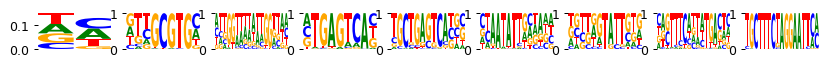

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.44it/s]


Current time: 2024-06-11 01:06:55.034454
	Loss: 258.620 , R2: 0.277
	Training time (model/function): (1.444s / 1.444s)
		per epoch (model/function): (0.103s/ 0.103s)
		per 1k samples: 0.132s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9986687396843166, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 50

### next filter to optimize 50 

FREEZING KERNELS
optimizing feature type mono
next kernels {50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 13.39it/s]


Current time: 2024-06-11 01:06:56.315255
	Loss: 239.587 , R2: 0.285
	Training time (model/function): (2.570s / 1.126s)
		per epoch (model/function): (0.184s/ 0.080s)
		per 1k samples: 0.103s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9986687396843166, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 14.36it/s]


Current time: 2024-06-11 01:06:57.517700
	Loss: 217.158 , R2: 0.285
	Training time (model/function): (3.620s / 1.050s)
		per epoch (model/function): (0.259s/ 0.075s)
		per 1k samples: 0.096s
best loss 217.158
last five r2 values, by sequential filter optimization: ['0.285']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9986687396843166, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 100

### next filter to optimize 100 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 12.59it/s]


Current time: 2024-06-11 01:06:59.008262
	Loss: 204.631 , R2: 0.289
	Training time (model/function): (4.818s / 1.197s)
		per epoch (model/function): (0.344s/ 0.086s)
		per 1k samples: 0.109s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9986687396843166, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 14.39it/s]


Current time: 2024-06-11 01:07:00.209195
	Loss: 187.524 , R2: 0.289
	Training time (model/function): (5.866s / 1.048s)
		per epoch (model/function): (0.419s/ 0.075s)
		per 1k samples: 0.096s
best loss 187.524
last five r2 values, by sequential filter optimization: ['0.285', '0.289']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9986687396843166, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 150

### next filter to optimize 150 

FREEZING KERNELS
optimizing feature type mono
next kernels {150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 13.36it/s]


Current time: 2024-06-11 01:07:01.629544
	Loss: 180.815 , R2: 0.292
	Training time (model/function): (6.994s / 1.128s)
		per epoch (model/function): (0.500s/ 0.081s)
		per 1k samples: 0.103s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9986687396843166, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 14.60it/s]


Current time: 2024-06-11 01:07:02.813853
	Loss: 169.001 , R2: 0.292
	Training time (model/function): (8.027s / 1.033s)
		per epoch (model/function): (0.573s/ 0.074s)
		per 1k samples: 0.094s
best loss 169.001
last five r2 values, by sequential filter optimization: ['0.285', '0.289', '0.292']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9986687396843166, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 200

### next filter to optimize 200 

FREEZING KERNELS
optimizing feature type mono
next kernels {200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 13.38it/s]


Current time: 2024-06-11 01:07:04.300800
	Loss: 166.655 , R2: 0.295
	Training time (model/function): (9.154s / 1.127s)
		per epoch (model/function): (0.654s/ 0.080s)
		per 1k samples: 0.103s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9986687396843166, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 14.67it/s]


Current time: 2024-06-11 01:07:05.481462
	Loss: 158.294 , R2: 0.295
	Training time (model/function): (10.182s / 1.028s)
		per epoch (model/function): (0.727s/ 0.073s)
		per 1k samples: 0.094s
best loss 158.294
last five r2 values, by sequential filter optimization: ['0.285', '0.289', '0.292', '0.295']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9986687396843166, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 250

### next filter to optimize 250 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 13.38it/s]


Current time: 2024-06-11 01:07:06.901301
	Loss: 158.596 , R2: 0.297
	Training time (model/function): (11.309s / 1.126s)
		per epoch (model/function): (0.808s/ 0.080s)
		per 1k samples: 0.103s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9986687396843166, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 14.65it/s]


Current time: 2024-06-11 01:07:08.082608
	Loss: 152.261 , R2: 0.297
	Training time (model/function): (12.338s / 1.029s)
		per epoch (model/function): (0.881s/ 0.074s)
		per 1k samples: 0.094s
best loss 152.261
last five r2 values, by sequential filter optimization: ['0.285', '0.289', '0.292', '0.295', '0.297']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9986687396843166, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 12.337990760803223s
Time per epoch (total): 0.003 s
saving model...
True /home/ilibarra/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/random/mubind_output/obs300/pwms/running_time.pkl
/home/ilibarra/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/episcanpy/pancreas_multiome_2022_processed_atac_obs300_var900.h5ad
pbmc (300, 924)
False /home/ilibarra/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/episcanpy/mubind_outp

Feature (chr13:119408725-119409719) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr14:115041769-115042655) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:122104543-122105449) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:122106704-122107546) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr15:102279025-102279932) beyond the length of chr15 size (101991189 bp).  Skipping.
Feature (chr15:102670633-102671518) beyond the length of chr15 size (101991189 bp).  Skipping.
Feature (chr15:102721758-102722660) beyond the length of chr15 size (101991189 bp).  Skipping.
Feature (chr15:103304875-103305793) beyond the length of chr15 size (101991189 bp).  Skipping.
Feature (chr16:90810027-90810905) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr16:92057738-92058674) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr16:93603438-93604351) beyond the length of c

(300, 812) (300, 46)
sum of reads 185166.0
(812, 301)
# cells 300
# peaks 812
selected (812, 300)
(46, 301)
# cells 300
# peaks 46
selected (46, 300)
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1

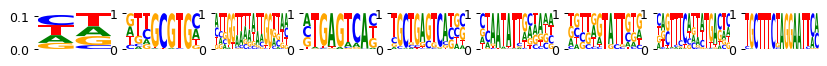

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 13.76it/s]


Current time: 2024-06-11 01:07:12.402842
	Loss: 259.339 , R2: 0.111
	Training time (model/function): (1.096s / 1.096s)
		per epoch (model/function): (0.078s/ 0.078s)
		per 1k samples: 0.096s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9994764341270116, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 50

### next filter to optimize 50 

FREEZING KERNELS
optimizing feature type mono
next kernels {50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 14.09it/s]


Current time: 2024-06-11 01:07:13.622158
	Loss: 240.289 , R2: 0.126
	Training time (model/function): (2.166s / 1.070s)
		per epoch (model/function): (0.155s/ 0.076s)
		per 1k samples: 0.094s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9994764341270116, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 15.39it/s]


Current time: 2024-06-11 01:07:14.750513
	Loss: 217.867 , R2: 0.126
	Training time (model/function): (3.146s / 0.980s)
		per epoch (model/function): (0.225s/ 0.070s)
		per 1k samples: 0.086s
best loss 217.867
last five r2 values, by sequential filter optimization: ['0.126']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9994764341270116, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 100

### next filter to optimize 100 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 13.00it/s]


Current time: 2024-06-11 01:07:16.196143
	Loss: 205.343 , R2: 0.131
	Training time (model/function): (4.306s / 1.159s)
		per epoch (model/function): (0.308s/ 0.083s)
		per 1k samples: 0.102s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9994764341270116, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 15.15it/s]


Current time: 2024-06-11 01:07:17.340006
	Loss: 188.230 , R2: 0.131
	Training time (model/function): (5.302s / 0.996s)
		per epoch (model/function): (0.379s/ 0.071s)
		per 1k samples: 0.088s
best loss 188.230
last five r2 values, by sequential filter optimization: ['0.126', '0.131']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9994764341270116, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 150

### next filter to optimize 150 

FREEZING KERNELS
optimizing feature type mono
next kernels {150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 13.91it/s]


Current time: 2024-06-11 01:07:18.710121
	Loss: 181.530 , R2: 0.132
	Training time (model/function): (6.386s / 1.084s)
		per epoch (model/function): (0.456s/ 0.077s)
		per 1k samples: 0.095s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9994764341270116, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 15.22it/s]


Current time: 2024-06-11 01:07:19.850389
	Loss: 169.705 , R2: 0.132
	Training time (model/function): (7.377s / 0.992s)
		per epoch (model/function): (0.527s/ 0.071s)
		per 1k samples: 0.087s
best loss 169.705
last five r2 values, by sequential filter optimization: ['0.126', '0.131', '0.132']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9994764341270116, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 200

### next filter to optimize 200 

FREEZING KERNELS
optimizing feature type mono
next kernels {200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 13.10it/s]


Current time: 2024-06-11 01:07:21.287764
	Loss: 167.366 , R2: 0.133
	Training time (model/function): (8.528s / 1.151s)
		per epoch (model/function): (0.609s/ 0.082s)
		per 1k samples: 0.101s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9994764341270116, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 15.34it/s]


Current time: 2024-06-11 01:07:22.419823
	Loss: 158.997 , R2: 0.133
	Training time (model/function): (9.512s / 0.983s)
		per epoch (model/function): (0.679s/ 0.070s)
		per 1k samples: 0.087s
best loss 158.997
last five r2 values, by sequential filter optimization: ['0.126', '0.131', '0.132', '0.133']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9994764341270116, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 250

### next filter to optimize 250 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 14.01it/s]


Current time: 2024-06-11 01:07:23.781976
	Loss: 159.313 , R2: 0.134
	Training time (model/function): (10.588s / 1.076s)
		per epoch (model/function): (0.756s/ 0.077s)
		per 1k samples: 0.095s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9994764341270116, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 15.38it/s]


Current time: 2024-06-11 01:07:24.911126
	Loss: 152.961 , R2: 0.134
	Training time (model/function): (11.569s / 0.981s)
		per epoch (model/function): (0.826s/ 0.070s)
		per 1k samples: 0.086s
best loss 152.961
last five r2 values, by sequential filter optimization: ['0.126', '0.131', '0.132', '0.133', '0.134']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9994764341270116, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 11.568867206573486s
Time per epoch (total): 0.003 s
saving model...
True /home/ilibarra/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/episcanpy/mubind_output/obs300/pwms/running_time.pkl
/home/ilibarra/workspace/theislab/mubind/data/pbmc/episcanpy/processed_laura_2023_obs500_var1500.h5ad
pbmc (500, 1495)
False /home/ilibarra/workspace/theislab/mubind/data/pbmc/episcanpy/mubind_output/obs500/pwms/model.pt
False /home/ilibarra/workspace/the

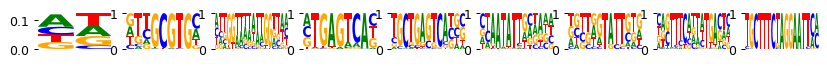

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 21.24it/s]


Current time: 2024-06-11 01:07:28.754914
	Loss: 266.993 , R2: 0.001
	Training time (model/function): (0.709s / 0.709s)
		per epoch (model/function): (0.051s/ 0.051s)
		per 1k samples: 0.190s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9875625379277708, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 50

### next filter to optimize 50 

FREEZING KERNELS
optimizing feature type mono
next kernels {50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 21.82it/s]


Current time: 2024-06-11 01:07:29.599855
	Loss: 258.425 , R2: 0.002
	Training time (model/function): (1.399s / 0.690s)
		per epoch (model/function): (0.100s/ 0.049s)
		per 1k samples: 0.185s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9875625379277708, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 23.30it/s]


Current time: 2024-06-11 01:07:30.478509
	Loss: 245.341 , R2: 0.002
	Training time (model/function): (2.046s / 0.647s)
		per epoch (model/function): (0.146s/ 0.046s)
		per 1k samples: 0.173s
best loss 245.341
last five r2 values, by sequential filter optimization: ['0.002']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9875625379277708, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 100

### next filter to optimize 100 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 21.65it/s]


Current time: 2024-06-11 01:07:31.465831
	Loss: 239.507 , R2: 0.003
	Training time (model/function): (2.741s / 0.696s)
		per epoch (model/function): (0.196s/ 0.050s)
		per 1k samples: 0.186s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9875625379277708, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 23.27it/s]


Current time: 2024-06-11 01:07:32.267293
	Loss: 226.191 , R2: 0.003
	Training time (model/function): (3.389s / 0.648s)
		per epoch (model/function): (0.242s/ 0.046s)
		per 1k samples: 0.173s
best loss 226.191
last five r2 values, by sequential filter optimization: ['0.002', '0.003']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9875625379277708, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 150

### next filter to optimize 150 

FREEZING KERNELS
optimizing feature type mono
next kernels {150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 19.68it/s]


Current time: 2024-06-11 01:07:33.325170
	Loss: 220.808 , R2: 0.003
	Training time (model/function): (4.154s / 0.765s)
		per epoch (model/function): (0.297s/ 0.055s)
		per 1k samples: 0.205s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9875625379277708, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 23.41it/s]


Current time: 2024-06-11 01:07:34.121169
	Loss: 208.449 , R2: 0.003
	Training time (model/function): (4.798s / 0.644s)
		per epoch (model/function): (0.343s/ 0.046s)
		per 1k samples: 0.172s
best loss 208.449
last five r2 values, by sequential filter optimization: ['0.002', '0.003', '0.003']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9875625379277708, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 200

### next filter to optimize 200 

FREEZING KERNELS
optimizing feature type mono
next kernels {200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 21.78it/s]


Current time: 2024-06-11 01:07:35.176280
	Loss: 204.355 , R2: 0.004
	Training time (model/function): (5.489s / 0.692s)
		per epoch (model/function): (0.392s/ 0.049s)
		per 1k samples: 0.185s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9875625379277708, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 23.47it/s]


Current time: 2024-06-11 01:07:35.974438
	Loss: 193.463 , R2: 0.004
	Training time (model/function): (6.131s / 0.642s)
		per epoch (model/function): (0.438s/ 0.046s)
		per 1k samples: 0.172s
best loss 193.463
last five r2 values, by sequential filter optimization: ['0.002', '0.003', '0.003', '0.004']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9875625379277708, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 250

### next filter to optimize 250 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 21.72it/s]


Current time: 2024-06-11 01:07:36.959916
	Loss: 190.887 , R2: 0.004
	Training time (model/function): (6.825s / 0.694s)
		per epoch (model/function): (0.488s/ 0.050s)
		per 1k samples: 0.186s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9875625379277708, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 23.45it/s]


Current time: 2024-06-11 01:07:37.755027
	Loss: 181.488 , R2: 0.004
	Training time (model/function): (7.468s / 0.642s)
		per epoch (model/function): (0.533s/ 0.046s)
		per 1k samples: 0.172s
best loss 181.488
last five r2 values, by sequential filter optimization: ['0.002', '0.003', '0.003', '0.004', '0.004']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9875625379277708, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 7.4675445556640625s
Time per epoch (total): 0.002 s
saving model...
True /home/ilibarra/workspace/theislab/mubind/data/pbmc/episcanpy/mubind_output/obs500/pwms/running_time.pkl
/home/ilibarra/workspace/theislab/mubind/data/noack_2022/random/merged_scATAC_integrated_cicero_faye_chong_obs500_var1500.h5ad
pbmc (500, 1500)
False /home/ilibarra/workspace/theislab/mubind/data/noack_2022/random/mubind_output/obs500/pwms/model.pt
False /home/ilibarra/workspace

Feature (chr14:117485092-117485592) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:117879309-117879809) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:121578965-121579465) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:122338648-122339148) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:122416315-122416815) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:122755462-122755962) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:124195753-124196253) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr16:91458915-91459415) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr16:91561523-91562023) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr16:92699199-92699699) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr16:93042432-93042932) beyond the length of chr1

preparing sequences test...
/tmp/tmpmkorff2a
genome hg19 False
/home/ilibarra/annotations/hg38/genome/hg38.fa
True /home/ilibarra/annotations/hg38/genome/hg38.fa
running bedtools...
['bedtools', 'getfasta', '-fi', '/home/ilibarra/annotations/hg38/genome/hg38.fa', '-bed', '/tmp/tmpmkorff2a', '-fo', '/tmp/tmpl4g_5s5k']
bedtools getfasta -fi /home/ilibarra/annotations/hg38/genome/hg38.fa -bed /tmp/tmpmkorff2a -fo /tmp/tmpl4g_5s5k
(500, 1319) (500, 74)
sum of reads 47221.0
(1319, 501)
# cells 500
# peaks 1319
selected (1311, 500)
(74, 501)
# cells 500
# peaks 74
selected (73, 500)
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,

Feature (chr13:117066581-117067443) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:118357799-118358681) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr14:114215408-114216284) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:117112740-117113561) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:117643087-117643642) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:119106246-119107142) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:124220712-124221556) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr16:90765005-90765782) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr16:91110812-91111743) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr17:87420047-87420617) beyond the length of chr17 size (83257441 bp).  Skipping.
Feature (chr17:87748468-87749239) beyond the length of chr1

preparing sequences test...
/tmp/tmpclc9s9_k
genome hg19 False
/home/ilibarra/annotations/hg38/genome/hg38.fa
True /home/ilibarra/annotations/hg38/genome/hg38.fa
running bedtools...
['bedtools', 'getfasta', '-fi', '/home/ilibarra/annotations/hg38/genome/hg38.fa', '-bed', '/tmp/tmpclc9s9_k', '-fo', '/tmp/tmpo390oc1t']
bedtools getfasta -fi /home/ilibarra/annotations/hg38/genome/hg38.fa -bed /tmp/tmpclc9s9_k -fo /tmp/tmpo390oc1t
(500, 1313) (500, 74)
sum of reads 486.0
(1313, 501)
# cells 500
# peaks 1313
selected (458, 500)
(74, 501)
# cells 500
# peaks 74
selected (25, 500)
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15

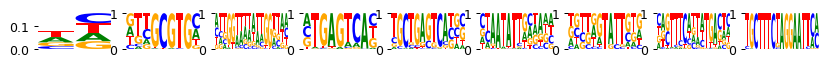

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 15.81it/s]


Current time: 2024-06-11 01:07:44.250230
	Loss: 266.993 , R2: 0.001
	Training time (model/function): (0.953s / 0.953s)
		per epoch (model/function): (0.068s/ 0.068s)
		per 1k samples: 0.149s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9829402711609281, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 50

### next filter to optimize 50 

FREEZING KERNELS
optimizing feature type mono
next kernels {50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 16.34it/s]


Current time: 2024-06-11 01:07:45.342897
	Loss: 258.425 , R2: 0.001
	Training time (model/function): (1.875s / 0.922s)
		per epoch (model/function): (0.134s/ 0.066s)
		per 1k samples: 0.144s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9829402711609281, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 17.06it/s]


Current time: 2024-06-11 01:07:46.395500
	Loss: 245.341 , R2: 0.001
	Training time (model/function): (2.758s / 0.883s)
		per epoch (model/function): (0.197s/ 0.063s)
		per 1k samples: 0.138s
best loss 245.341
last five r2 values, by sequential filter optimization: ['0.001']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9829402711609281, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 100

### next filter to optimize 100 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 16.36it/s]


Current time: 2024-06-11 01:07:47.641583
	Loss: 239.507 , R2: 0.002
	Training time (model/function): (3.679s / 0.921s)
		per epoch (model/function): (0.263s/ 0.066s)
		per 1k samples: 0.144s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9829402711609281, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 17.01it/s]


Current time: 2024-06-11 01:07:48.764044
	Loss: 226.191 , R2: 0.002
	Training time (model/function): (4.633s / 0.954s)
		per epoch (model/function): (0.331s/ 0.068s)
		per 1k samples: 0.149s
best loss 226.191
last five r2 values, by sequential filter optimization: ['0.001', '0.002']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9829402711609281, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 150

### next filter to optimize 150 

FREEZING KERNELS
optimizing feature type mono
next kernels {150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 16.34it/s]


Current time: 2024-06-11 01:07:50.011742
	Loss: 220.804 , R2: 0.002
	Training time (model/function): (5.555s / 0.922s)
		per epoch (model/function): (0.397s/ 0.066s)
		per 1k samples: 0.144s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9829402711609281, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 16.99it/s]


Current time: 2024-06-11 01:07:51.139543
	Loss: 208.449 , R2: 0.002
	Training time (model/function): (6.442s / 0.887s)
		per epoch (model/function): (0.460s/ 0.063s)
		per 1k samples: 0.138s
best loss 208.449
last five r2 values, by sequential filter optimization: ['0.001', '0.002', '0.002']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9829402711609281, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 200

### next filter to optimize 200 

FREEZING KERNELS
optimizing feature type mono
next kernels {200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 16.30it/s]


Current time: 2024-06-11 01:07:52.389201
	Loss: 204.349 , R2: 0.002
	Training time (model/function): (7.367s / 0.925s)
		per epoch (model/function): (0.526s/ 0.066s)
		per 1k samples: 0.144s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9829402711609281, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 17.15it/s]


Current time: 2024-06-11 01:07:53.435959
	Loss: 193.463 , R2: 0.002
	Training time (model/function): (8.246s / 0.879s)
		per epoch (model/function): (0.589s/ 0.063s)
		per 1k samples: 0.137s
best loss 193.463
last five r2 values, by sequential filter optimization: ['0.001', '0.002', '0.002', '0.002']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9829402711609281, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 250

### next filter to optimize 250 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 15.19it/s]


Current time: 2024-06-11 01:07:54.753865
	Loss: 190.880 , R2: 0.003
	Training time (model/function): (9.238s / 0.992s)
		per epoch (model/function): (0.660s/ 0.071s)
		per 1k samples: 0.155s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9829402711609281, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 17.14it/s]


Current time: 2024-06-11 01:07:55.802220
	Loss: 181.488 , R2: 0.003
	Training time (model/function): (10.117s / 0.879s)
		per epoch (model/function): (0.723s/ 0.063s)
		per 1k samples: 0.137s
best loss 181.488
last five r2 values, by sequential filter optimization: ['0.001', '0.002', '0.002', '0.002', '0.003']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9829402711609281, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 10.1169593334198s
Time per epoch (total): 0.002 s
saving model...
True /home/ilibarra/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/episcanpy/mubind_output/obs500/pwms/running_time.pkl
/home/ilibarra/workspace/theislab/mubind/data/pbmc/random/processed_laura_2023_obs500_var1500.h5ad
pbmc (500, 1500)
False /home/ilibarra/workspace/theislab/mubind/data/pbmc/random/mubind_output/obs500/pwms/model.pt
False /home/ilibarra/workspace/theislab/mu

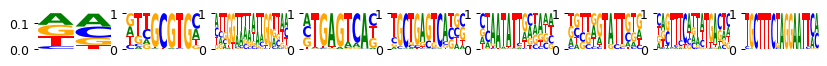

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  7.89it/s]


Current time: 2024-06-11 01:08:01.490662
	Loss: 249.019 , R2: 0.329
	Training time (model/function): (1.912s / 1.912s)
		per epoch (model/function): (0.137s/ 0.137s)
		per 1k samples: 0.102s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991488269714497, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 50

### next filter to optimize 50 

FREEZING KERNELS
optimizing feature type mono
next kernels {50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  7.96it/s]


Current time: 2024-06-11 01:08:03.608465
	Loss: 220.739 , R2: 0.332
	Training time (model/function): (3.806s / 1.894s)
		per epoch (model/function): (0.272s/ 0.135s)
		per 1k samples: 0.101s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991488269714497, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  8.34it/s]


Current time: 2024-06-11 01:08:05.729529
	Loss: 193.940 , R2: 0.332
	Training time (model/function): (5.614s / 1.808s)
		per epoch (model/function): (0.401s/ 0.129s)
		per 1k samples: 0.096s
best loss 193.940
last five r2 values, by sequential filter optimization: ['0.332']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991488269714497, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 100

### next filter to optimize 100 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  7.63it/s]


Current time: 2024-06-11 01:08:08.153762
	Loss: 181.193 , R2: 0.334
	Training time (model/function): (7.592s / 1.977s)
		per epoch (model/function): (0.542s/ 0.141s)
		per 1k samples: 0.105s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991488269714497, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  8.21it/s]


Current time: 2024-06-11 01:08:10.213350
	Loss: 166.196 , R2: 0.333
	Training time (model/function): (9.429s / 1.838s)
		per epoch (model/function): (0.674s/ 0.131s)
		per 1k samples: 0.098s
best loss 166.196
last five r2 values, by sequential filter optimization: ['0.332', '0.333']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991488269714497, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 150

### next filter to optimize 150 

FREEZING KERNELS
optimizing feature type mono
next kernels {150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  7.56it/s]


Current time: 2024-06-11 01:08:12.646185
	Loss: 162.529 , R2: 0.335
	Training time (model/function): (11.424s / 1.995s)
		per epoch (model/function): (0.816s/ 0.142s)
		per 1k samples: 0.106s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991488269714497, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  8.41it/s]


Current time: 2024-06-11 01:08:14.659451
	Loss: 153.857 , R2: 0.335
	Training time (model/function): (13.216s / 1.793s)
		per epoch (model/function): (0.944s/ 0.128s)
		per 1k samples: 0.096s
best loss 153.857
last five r2 values, by sequential filter optimization: ['0.332', '0.333', '0.335']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991488269714497, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 200

### next filter to optimize 200 

FREEZING KERNELS
optimizing feature type mono
next kernels {200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  7.89it/s]


Current time: 2024-06-11 01:08:17.002014
	Loss: 154.422 , R2: 0.336
	Training time (model/function): (15.127s / 1.910s)
		per epoch (model/function): (1.080s/ 0.136s)
		per 1k samples: 0.102s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991488269714497, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  8.16it/s]


Current time: 2024-06-11 01:08:19.071873
	Loss: 148.561 , R2: 0.335
	Training time (model/function): (16.974s / 1.848s)
		per epoch (model/function): (1.212s/ 0.132s)
		per 1k samples: 0.099s
best loss 148.561
last five r2 values, by sequential filter optimization: ['0.332', '0.333', '0.335', '0.335']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991488269714497, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 250

### next filter to optimize 250 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  7.88it/s]


Current time: 2024-06-11 01:08:21.419403
	Loss: 150.975 , R2: 0.338
	Training time (model/function): (18.888s / 1.914s)
		per epoch (model/function): (1.349s/ 0.137s)
		per 1k samples: 0.102s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991488269714497, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  8.47it/s]


Current time: 2024-06-11 01:08:23.491394
	Loss: 146.305 , R2: 0.337
	Training time (model/function): (20.669s / 1.781s)
		per epoch (model/function): (1.476s/ 0.127s)
		per 1k samples: 0.095s
best loss 146.305
last five r2 values, by sequential filter optimization: ['0.332', '0.333', '0.335', '0.335', '0.337']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991488269714497, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 20.66924810409546s
Time per epoch (total): 0.005 s
saving model...
True /home/ilibarra/workspace/theislab/mubind/data/pbmc/random/mubind_output/obs500/pwms/running_time.pkl
/home/ilibarra/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/random/pancreas_multiome_2022_processed_atac_obs500_var1500.h5ad
pbmc (500, 1500)
False /home/ilibarra/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/random/mubind_output/obs500/pwms/model.pt
Fals

Feature (chr13:115352911-115353432) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:119378125-119379065) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr14:114855551-114856326) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:115585520-115586432) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:117354228-117355157) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:117455833-117456719) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:118619604-118620475) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:120142223-120142934) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:120755292-120756139) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:121348025-121348898) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:121781115-121781885) beyond the len

preparing sequences test...
/tmp/tmph6z0012y
genome hg19 False
/home/ilibarra/annotations/hg38/genome/hg38.fa
True /home/ilibarra/annotations/hg38/genome/hg38.fa
running bedtools...
['bedtools', 'getfasta', '-fi', '/home/ilibarra/annotations/hg38/genome/hg38.fa', '-bed', '/tmp/tmph6z0012y', '-fo', '/tmp/tmp9iq_6oy1']
bedtools getfasta -fi /home/ilibarra/annotations/hg38/genome/hg38.fa -bed /tmp/tmph6z0012y -fo /tmp/tmp9iq_6oy1
(500, 1317) (500, 75)
sum of reads 50060.0
(1317, 501)
# cells 500
# peaks 1317
selected (1311, 500)
(75, 501)
# cells 500
# peaks 75
selected (75, 500)
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,

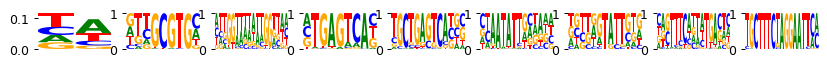

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.36it/s]


Current time: 2024-06-11 01:08:30.177560
	Loss: 249.002 , R2: 0.314
	Training time (model/function): (2.371s / 2.371s)
		per epoch (model/function): (0.169s/ 0.169s)
		per 1k samples: 0.129s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991171911428638, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 50

### next filter to optimize 50 

FREEZING KERNELS
optimizing feature type mono
next kernels {50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.63it/s]


Current time: 2024-06-11 01:08:32.761404
	Loss: 220.725 , R2: 0.318
	Training time (model/function): (4.645s / 2.274s)
		per epoch (model/function): (0.332s/ 0.162s)
		per 1k samples: 0.124s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991171911428638, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.00it/s]


Current time: 2024-06-11 01:08:35.223523
	Loss: 193.925 , R2: 0.318
	Training time (model/function): (6.799s / 2.154s)
		per epoch (model/function): (0.486s/ 0.154s)
		per 1k samples: 0.117s
best loss 193.925
last five r2 values, by sequential filter optimization: ['0.318']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991171911428638, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 100

### next filter to optimize 100 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.49it/s]


Current time: 2024-06-11 01:08:38.230798
	Loss: 181.179 , R2: 0.320
	Training time (model/function): (9.119s / 2.320s)
		per epoch (model/function): (0.651s/ 0.166s)
		per 1k samples: 0.126s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991171911428638, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.82it/s]


Current time: 2024-06-11 01:08:40.761326
	Loss: 166.177 , R2: 0.320
	Training time (model/function): (11.332s / 2.213s)
		per epoch (model/function): (0.809s/ 0.158s)
		per 1k samples: 0.121s
best loss 166.177
last five r2 values, by sequential filter optimization: ['0.318', '0.320']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991171911428638, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 150

### next filter to optimize 150 

FREEZING KERNELS
optimizing feature type mono
next kernels {150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.49it/s]


Current time: 2024-06-11 01:08:43.771307
	Loss: 162.496 , R2: 0.321
	Training time (model/function): (13.653s / 2.321s)
		per epoch (model/function): (0.975s/ 0.166s)
		per 1k samples: 0.126s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991171911428638, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.78it/s]


Current time: 2024-06-11 01:08:46.307066
	Loss: 153.839 , R2: 0.321
	Training time (model/function): (15.876s / 2.223s)
		per epoch (model/function): (1.134s/ 0.159s)
		per 1k samples: 0.121s
best loss 153.839
last five r2 values, by sequential filter optimization: ['0.318', '0.320', '0.321']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991171911428638, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 200

### next filter to optimize 200 

FREEZING KERNELS
optimizing feature type mono
next kernels {200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.51it/s]


Current time: 2024-06-11 01:08:49.244861
	Loss: 154.392 , R2: 0.322
	Training time (model/function): (18.192s / 2.315s)
		per epoch (model/function): (1.299s/ 0.165s)
		per 1k samples: 0.126s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991171911428638, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.88it/s]


Current time: 2024-06-11 01:08:51.820594
	Loss: 148.542 , R2: 0.322
	Training time (model/function): (20.383s / 2.191s)
		per epoch (model/function): (1.456s/ 0.157s)
		per 1k samples: 0.119s
best loss 148.542
last five r2 values, by sequential filter optimization: ['0.318', '0.320', '0.321', '0.322']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991171911428638, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 250

### next filter to optimize 250 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.48it/s]


Current time: 2024-06-11 01:08:54.760711
	Loss: 150.940 , R2: 0.323
	Training time (model/function): (22.710s / 2.327s)
		per epoch (model/function): (1.622s/ 0.166s)
		per 1k samples: 0.127s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991171911428638, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.86it/s]


Current time: 2024-06-11 01:08:57.343022
	Loss: 146.289 , R2: 0.323
	Training time (model/function): (24.906s / 2.196s)
		per epoch (model/function): (1.779s/ 0.157s)
		per 1k samples: 0.120s
best loss 146.289
last five r2 values, by sequential filter optimization: ['0.318', '0.320', '0.321', '0.322', '0.323']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991171911428638, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 24.90578818321228s
Time per epoch (total): 0.006 s
saving model...
True /home/ilibarra/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/random/mubind_output/obs500/pwms/running_time.pkl
/home/ilibarra/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/episcanpy/pancreas_multiome_2022_processed_atac_obs1000_var3000.h5ad
pbmc (1000, 3000)
False /home/ilibarra/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/episcanpy/mubind_o

Feature (chr13:114815403-114816207) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:115352180-115352554) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:116521163-116522001) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:117205908-117206788) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:118669717-118670226) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:119491754-119492694) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr14:107795917-107796824) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:108815499-108816584) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:111149465-111150334) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:114434355-114435246) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:115232765-115233689) beyond the len

preparing sequences test...
/tmp/tmpnw51e4v0
genome hg19 False
/home/ilibarra/annotations/hg38/genome/hg38.fa
True /home/ilibarra/annotations/hg38/genome/hg38.fa
running bedtools...
['bedtools', 'getfasta', '-fi', '/home/ilibarra/annotations/hg38/genome/hg38.fa', '-bed', '/tmp/tmpnw51e4v0', '-fo', '/tmp/tmpy8nlwzht']
bedtools getfasta -fi /home/ilibarra/annotations/hg38/genome/hg38.fa -bed /tmp/tmpnw51e4v0 -fo /tmp/tmpy8nlwzht
(1000, 2626) (1000, 144)
sum of reads 7997.0
(2626, 1001)
# cells 1000
# peaks 2626
selected (2580, 1000)
(144, 1001)
# cells 1000
# peaks 144
selected (140, 1000)
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 

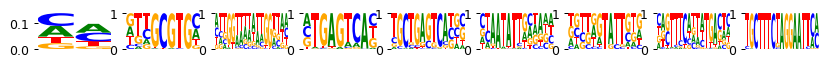

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.06it/s]


Current time: 2024-06-11 01:09:06.972175
	Loss: 219.628 , R2: 0.002
	Training time (model/function): (3.715s / 3.715s)
		per epoch (model/function): (0.265s/ 0.265s)
		per 1k samples: 0.103s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.970709123678132, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 50

### next filter to optimize 50 

FREEZING KERNELS
optimizing feature type mono
next kernels {50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.20it/s]


Current time: 2024-06-11 01:09:11.281152
	Loss: 182.078 , R2: 0.002
	Training time (model/function): (7.318s / 3.603s)
		per epoch (model/function): (0.523s/ 0.257s)
		per 1k samples: 0.100s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.970709123678132, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.27it/s]


Current time: 2024-06-11 01:09:15.525855
	Loss: 160.067 , R2: 0.002
	Training time (model/function): (10.857s / 3.539s)
		per epoch (model/function): (0.775s/ 0.253s)
		per 1k samples: 0.098s
best loss 160.067
last five r2 values, by sequential filter optimization: ['0.002']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.970709123678132, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 100

### next filter to optimize 100 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.14it/s]


Current time: 2024-06-11 01:09:20.576200
	Loss: 155.391 , R2: 0.002
	Training time (model/function): (14.503s / 3.647s)
		per epoch (model/function): (1.036s/ 0.260s)
		per 1k samples: 0.101s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.970709123678132, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.36it/s]


Current time: 2024-06-11 01:09:24.835176
	Loss: 147.737 , R2: 0.002
	Training time (model/function): (17.972s / 3.469s)
		per epoch (model/function): (1.284s/ 0.248s)
		per 1k samples: 0.096s
best loss 147.737
last five r2 values, by sequential filter optimization: ['0.002', '0.002']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.970709123678132, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 150

### next filter to optimize 150 

FREEZING KERNELS
optimizing feature type mono
next kernels {150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.23it/s]


Current time: 2024-06-11 01:09:29.892285
	Loss: 149.726 , R2: 0.002
	Training time (model/function): (21.542s / 3.570s)
		per epoch (model/function): (1.539s/ 0.255s)
		per 1k samples: 0.099s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.970709123678132, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.36it/s]


Current time: 2024-06-11 01:09:34.067473
	Loss: 145.146 , R2: 0.002
	Training time (model/function): (25.012s / 3.469s)
		per epoch (model/function): (1.787s/ 0.248s)
		per 1k samples: 0.096s
best loss 145.146
last five r2 values, by sequential filter optimization: ['0.002', '0.002', '0.002']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.970709123678132, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 200

### next filter to optimize 200 

FREEZING KERNELS
optimizing feature type mono
next kernels {200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.15it/s]


Current time: 2024-06-11 01:09:39.111295
	Loss: 148.529 , R2: 0.002
	Training time (model/function): (28.655s / 3.644s)
		per epoch (model/function): (2.047s/ 0.260s)
		per 1k samples: 0.101s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.970709123678132, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.39it/s]


Current time: 2024-06-11 01:09:43.328278
	Loss: 144.602 , R2: 0.002
	Training time (model/function): (32.097s / 3.441s)
		per epoch (model/function): (2.293s/ 0.246s)
		per 1k samples: 0.095s
best loss 144.602
last five r2 values, by sequential filter optimization: ['0.002', '0.002', '0.002', '0.002']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.970709123678132, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 250

### next filter to optimize 250 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.21it/s]


Current time: 2024-06-11 01:09:48.384383
	Loss: 148.283 , R2: 0.003
	Training time (model/function): (35.683s / 3.587s)
		per epoch (model/function): (2.549s/ 0.256s)
		per 1k samples: 0.099s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.970709123678132, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.37it/s]


Current time: 2024-06-11 01:09:52.546629
	Loss: 144.488 , R2: 0.003
	Training time (model/function): (39.139s / 3.456s)
		per epoch (model/function): (2.796s/ 0.247s)
		per 1k samples: 0.096s
best loss 144.488
last five r2 values, by sequential filter optimization: ['0.002', '0.002', '0.002', '0.002', '0.003']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.970709123678132, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 39.13935661315918s
Time per epoch (total): 0.009 s
saving model...
True /home/ilibarra/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/episcanpy/mubind_output/obs1000/pwms/running_time.pkl
/home/ilibarra/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/random/pancreas_multiome_2022_processed_atac_obs1000_var3000.h5ad
pbmc (1000, 3000)
False /home/ilibarra/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/random/mubind_outp

Feature (chr13:116707480-116708344) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr14:107306777-107307625) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:109667875-109668739) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:109739829-109740724) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:115475048-115475932) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:115682328-115683186) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:117552504-117553382) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:117992179-117992875) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:118461748-118462650) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:119847227-119848053) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:119947293-119948195) beyond the len

preparing sequences test...
/tmp/tmp77ssgt0n
genome hg19 False
/home/ilibarra/annotations/hg38/genome/hg38.fa
True /home/ilibarra/annotations/hg38/genome/hg38.fa
running bedtools...
['bedtools', 'getfasta', '-fi', '/home/ilibarra/annotations/hg38/genome/hg38.fa', '-bed', '/tmp/tmp77ssgt0n', '-fo', '/tmp/tmpw8ayqbj_']
bedtools getfasta -fi /home/ilibarra/annotations/hg38/genome/hg38.fa -bed /tmp/tmp77ssgt0n -fo /tmp/tmpw8ayqbj_
(1000, 2636) (1000, 148)
sum of reads 197837.0
(2636, 1001)
# cells 1000
# peaks 2636
selected (2636, 1000)
(148, 1001)
# cells 1000
# peaks 148
selected (148, 1000)
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15

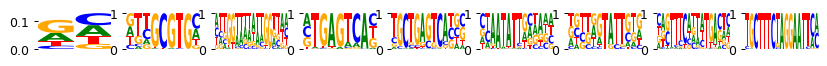

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.20it/s]


Current time: 2024-06-11 01:10:07.246373
	Loss: 219.788 , R2: 0.289
	Training time (model/function): (4.725s / 4.725s)
		per epoch (model/function): (0.338s/ 0.338s)
		per 1k samples: 0.128s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9974616424155597, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 50

### next filter to optimize 50 

FREEZING KERNELS
optimizing feature type mono
next kernels {50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.10it/s]


Current time: 2024-06-11 01:10:12.935193
	Loss: 182.241 , R2: 0.291
	Training time (model/function): (9.603s / 4.877s)
		per epoch (model/function): (0.686s/ 0.348s)
		per 1k samples: 0.132s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9974616424155597, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.16it/s]


Current time: 2024-06-11 01:10:18.600526
	Loss: 160.230 , R2: 0.291
	Training time (model/function): (14.393s / 4.791s)
		per epoch (model/function): (1.028s/ 0.342s)
		per 1k samples: 0.130s
best loss 160.230
last five r2 values, by sequential filter optimization: ['0.291']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9974616424155597, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 100

### next filter to optimize 100 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.10it/s]


Current time: 2024-06-11 01:10:25.151714
	Loss: 155.553 , R2: 0.292
	Training time (model/function): (19.262s / 4.869s)
		per epoch (model/function): (1.376s/ 0.348s)
		per 1k samples: 0.132s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9974616424155597, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.14it/s]


Current time: 2024-06-11 01:10:30.769375
	Loss: 147.904 , R2: 0.292
	Training time (model/function): (24.081s / 4.819s)
		per epoch (model/function): (1.720s/ 0.344s)
		per 1k samples: 0.131s
best loss 147.904
last five r2 values, by sequential filter optimization: ['0.291', '0.292']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9974616424155597, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 150

### next filter to optimize 150 

FREEZING KERNELS
optimizing feature type mono
next kernels {150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.11it/s]


Current time: 2024-06-11 01:10:37.297358
	Loss: 149.886 , R2: 0.293
	Training time (model/function): (28.941s / 4.860s)
		per epoch (model/function): (2.067s/ 0.347s)
		per 1k samples: 0.132s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9974616424155597, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.11it/s]


Current time: 2024-06-11 01:10:42.960523
	Loss: 145.311 , R2: 0.293
	Training time (model/function): (33.802s / 4.862s)
		per epoch (model/function): (2.414s/ 0.347s)
		per 1k samples: 0.132s
best loss 145.311
last five r2 values, by sequential filter optimization: ['0.291', '0.292', '0.293']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9974616424155597, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 200

### next filter to optimize 200 

FREEZING KERNELS
optimizing feature type mono
next kernels {200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.10it/s]


Current time: 2024-06-11 01:10:49.491211
	Loss: 148.698 , R2: 0.293
	Training time (model/function): (38.669s / 4.867s)
		per epoch (model/function): (2.762s/ 0.348s)
		per 1k samples: 0.132s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9974616424155597, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.20it/s]


Current time: 2024-06-11 01:10:55.028869
	Loss: 144.767 , R2: 0.294
	Training time (model/function): (43.392s / 4.723s)
		per epoch (model/function): (3.099s/ 0.337s)
		per 1k samples: 0.128s
best loss 144.767
last five r2 values, by sequential filter optimization: ['0.291', '0.292', '0.293', '0.294']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9974616424155597, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 250

### next filter to optimize 250 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.10it/s]


Current time: 2024-06-11 01:11:01.570777
	Loss: 148.435 , R2: 0.296
	Training time (model/function): (48.265s / 4.873s)
		per epoch (model/function): (3.448s/ 0.348s)
		per 1k samples: 0.132s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9974616424155597, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.19it/s]


Current time: 2024-06-11 01:11:07.188891
	Loss: 144.652 , R2: 0.296
	Training time (model/function): (53.006s / 4.740s)
		per epoch (model/function): (3.786s/ 0.339s)
		per 1k samples: 0.128s
best loss 144.652
last five r2 values, by sequential filter optimization: ['0.291', '0.292', '0.293', '0.294', '0.296']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9974616424155597, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 53.00580072402954s
Time per epoch (total): 0.012 s
saving model...
True /home/ilibarra/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/random/mubind_output/obs1000/pwms/running_time.pkl
/home/ilibarra/workspace/theislab/mubind/data/noack_2022/episcanpy/merged_scATAC_integrated_cicero_faye_chong_obs1000_var3000.h5ad
pbmc (1000, 3000)
False /home/ilibarra/workspace/theislab/mubind/data/noack_2022/episcanpy/mubind_output/obs1000/pwms/model.pt


Feature (chr13:115418438-115418938) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:117241985-117242485) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:118140156-118140656) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:118420347-118420847) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr14:110524386-110524886) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:110827403-110827903) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:110926774-110927274) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:111369385-111369885) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:111454139-111454639) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:111785933-111786433) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:112621813-112622313) beyond the len

preparing sequences test...
/tmp/tmpfp638bre
genome hg19 False
/home/ilibarra/annotations/hg38/genome/hg38.fa
True /home/ilibarra/annotations/hg38/genome/hg38.fa
running bedtools...
['bedtools', 'getfasta', '-fi', '/home/ilibarra/annotations/hg38/genome/hg38.fa', '-bed', '/tmp/tmpfp638bre', '-fo', '/tmp/tmplhd_2z9p']
bedtools getfasta -fi /home/ilibarra/annotations/hg38/genome/hg38.fa -bed /tmp/tmpfp638bre -fo /tmp/tmplhd_2z9p
(1000, 2647) (1000, 146)
sum of reads 4001.0
(2647, 1001)
# cells 1000
# peaks 2647
selected (2409, 1000)
(146, 1001)
# cells 1000
# peaks 146
selected (135, 1000)
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 

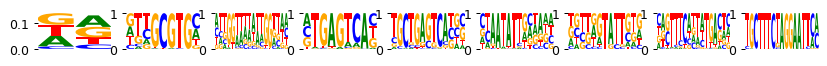

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.08it/s]


Current time: 2024-06-11 01:11:19.120526
	Loss: 228.820 , R2: 0.002
	Training time (model/function): (2.485s / 2.485s)
		per epoch (model/function): (0.177s/ 0.177s)
		per 1k samples: 0.074s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9922985552707221, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 50

### next filter to optimize 50 

FREEZING KERNELS
optimizing feature type mono
next kernels {50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.11it/s]


Current time: 2024-06-11 01:11:22.317111
	Loss: 191.698 , R2: 0.003
	Training time (model/function): (4.956s / 2.471s)
		per epoch (model/function): (0.354s/ 0.177s)
		per 1k samples: 0.073s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9922985552707221, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.25it/s]


Current time: 2024-06-11 01:11:25.367815
	Loss: 166.984 , R2: 0.003
	Training time (model/function): (7.374s / 2.418s)
		per epoch (model/function): (0.527s/ 0.173s)
		per 1k samples: 0.072s
best loss 166.984
last five r2 values, by sequential filter optimization: ['0.003']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9922985552707221, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 100

### next filter to optimize 100 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.81it/s]


Current time: 2024-06-11 01:11:29.195127
	Loss: 159.786 , R2: 0.004
	Training time (model/function): (9.972s / 2.598s)
		per epoch (model/function): (0.712s/ 0.186s)
		per 1k samples: 0.077s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9922985552707221, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.19it/s]


Current time: 2024-06-11 01:11:32.258122
	Loss: 150.365 , R2: 0.004
	Training time (model/function): (12.411s / 2.439s)
		per epoch (model/function): (0.886s/ 0.174s)
		per 1k samples: 0.072s
best loss 150.365
last five r2 values, by sequential filter optimization: ['0.003', '0.004']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9922985552707221, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 150

### next filter to optimize 150 

FREEZING KERNELS
optimizing feature type mono
next kernels {150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.04it/s]


Current time: 2024-06-11 01:11:36.070012
	Loss: 151.241 , R2: 0.004
	Training time (model/function): (14.911s / 2.500s)
		per epoch (model/function): (1.065s/ 0.179s)
		per 1k samples: 0.074s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9922985552707221, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.08it/s]


Current time: 2024-06-11 01:11:39.179225
	Loss: 145.996 , R2: 0.004
	Training time (model/function): (17.396s / 2.485s)
		per epoch (model/function): (1.243s/ 0.178s)
		per 1k samples: 0.074s
best loss 145.996
last five r2 values, by sequential filter optimization: ['0.003', '0.004', '0.004']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9922985552707221, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 200

### next filter to optimize 200 

FREEZING KERNELS
optimizing feature type mono
next kernels {200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.83it/s]


Current time: 2024-06-11 01:11:42.999078
	Loss: 148.997 , R2: 0.005
	Training time (model/function): (19.985s / 2.589s)
		per epoch (model/function): (1.427s/ 0.185s)
		per 1k samples: 0.077s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9922985552707221, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.32it/s]


Current time: 2024-06-11 01:11:46.081891
	Loss: 144.854 , R2: 0.005
	Training time (model/function): (22.374s / 2.389s)
		per epoch (model/function): (1.598s/ 0.171s)
		per 1k samples: 0.071s
best loss 144.854
last five r2 values, by sequential filter optimization: ['0.003', '0.004', '0.004', '0.005']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9922985552707221, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 250

### next filter to optimize 250 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.00it/s]


Current time: 2024-06-11 01:11:49.825647
	Loss: 148.413 , R2: 0.005
	Training time (model/function): (24.890s / 2.516s)
		per epoch (model/function): (1.778s/ 0.180s)
		per 1k samples: 0.075s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9922985552707221, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.11it/s]


Current time: 2024-06-11 01:11:52.935843
	Loss: 144.555 , R2: 0.005
	Training time (model/function): (27.363s / 2.473s)
		per epoch (model/function): (1.954s/ 0.177s)
		per 1k samples: 0.073s
best loss 144.555
last five r2 values, by sequential filter optimization: ['0.003', '0.004', '0.004', '0.005', '0.005']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9922985552707221, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 27.362956523895264s
Time per epoch (total): 0.006 s
saving model...
True /home/ilibarra/workspace/theislab/mubind/data/noack_2022/episcanpy/mubind_output/obs1000/pwms/running_time.pkl
/home/ilibarra/workspace/theislab/mubind/data/noack_2022/random/merged_scATAC_integrated_cicero_faye_chong_obs1000_var3000.h5ad
pbmc (1000, 3000)
False /home/ilibarra/workspace/theislab/mubind/data/noack_2022/random/mubind_output/obs1000/pwms/model.pt
False /home/ilibarr

Feature (chr13:118791736-118792236) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:119966157-119966657) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr14:109659503-109660003) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:109984931-109985431) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:110047647-110048147) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:111295459-111295959) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:114888951-114889451) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:115668545-115669045) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:115745929-115746429) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:116945147-116945647) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:118231866-118232366) beyond the len

preparing sequences test...
/tmp/tmpysy3e2d3
genome hg19 False
/home/ilibarra/annotations/hg38/genome/hg38.fa
True /home/ilibarra/annotations/hg38/genome/hg38.fa
running bedtools...
['bedtools', 'getfasta', '-fi', '/home/ilibarra/annotations/hg38/genome/hg38.fa', '-bed', '/tmp/tmpysy3e2d3', '-fo', '/tmp/tmp7p9xv07g']
bedtools getfasta -fi /home/ilibarra/annotations/hg38/genome/hg38.fa -bed /tmp/tmpysy3e2d3 -fo /tmp/tmp7p9xv07g
(1000, 2640) (1000, 147)
sum of reads 191705.0
(2640, 1001)
# cells 1000
# peaks 2640
selected (2634, 1000)
(147, 1001)
# cells 1000
# peaks 147
selected (147, 1000)
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15

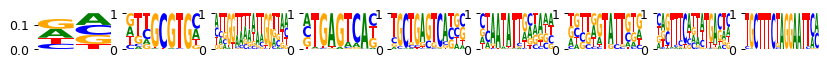

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.20it/s]


Current time: 2024-06-11 01:12:04.231193
	Loss: 219.814 , R2: 0.191
	Training time (model/function): (2.903s / 2.903s)
		per epoch (model/function): (0.207s/ 0.207s)
		per 1k samples: 0.079s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9964946010886779, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 50

### next filter to optimize 50 

FREEZING KERNELS
optimizing feature type mono
next kernels {50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.16it/s]


Current time: 2024-06-11 01:12:07.818844
	Loss: 182.271 , R2: 0.192
	Training time (model/function): (5.829s / 2.926s)
		per epoch (model/function): (0.416s/ 0.209s)
		per 1k samples: 0.079s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9964946010886779, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.24it/s]


Current time: 2024-06-11 01:12:11.451475
	Loss: 160.257 , R2: 0.192
	Training time (model/function): (8.710s / 2.881s)
		per epoch (model/function): (0.622s/ 0.206s)
		per 1k samples: 0.078s
best loss 160.257
last five r2 values, by sequential filter optimization: ['0.192']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9964946010886779, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 100

### next filter to optimize 100 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.16it/s]


Current time: 2024-06-11 01:12:15.774261
	Loss: 155.584 , R2: 0.193
	Training time (model/function): (11.637s / 2.927s)
		per epoch (model/function): (0.831s/ 0.209s)
		per 1k samples: 0.079s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9964946010886779, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.33it/s]


Current time: 2024-06-11 01:12:19.270558
	Loss: 147.928 , R2: 0.193
	Training time (model/function): (14.469s / 2.832s)
		per epoch (model/function): (1.034s/ 0.202s)
		per 1k samples: 0.077s
best loss 147.928
last five r2 values, by sequential filter optimization: ['0.192', '0.193']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9964946010886779, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 150

### next filter to optimize 150 

FREEZING KERNELS
optimizing feature type mono
next kernels {150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.99it/s]


Current time: 2024-06-11 01:12:23.605887
	Loss: 149.914 , R2: 0.193
	Training time (model/function): (17.491s / 3.022s)
		per epoch (model/function): (1.249s/ 0.216s)
		per 1k samples: 0.082s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9964946010886779, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.37it/s]


Current time: 2024-06-11 01:12:27.162298
	Loss: 145.338 , R2: 0.193
	Training time (model/function): (20.305s / 2.814s)
		per epoch (model/function): (1.450s/ 0.201s)
		per 1k samples: 0.076s
best loss 145.338
last five r2 values, by sequential filter optimization: ['0.192', '0.193', '0.193']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9964946010886779, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 200

### next filter to optimize 200 

FREEZING KERNELS
optimizing feature type mono
next kernels {200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.13it/s]


Current time: 2024-06-11 01:12:31.429824
	Loss: 148.722 , R2: 0.194
	Training time (model/function): (23.248s / 2.943s)
		per epoch (model/function): (1.661s/ 0.210s)
		per 1k samples: 0.080s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9964946010886779, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.30it/s]


Current time: 2024-06-11 01:12:34.947923
	Loss: 144.795 , R2: 0.194
	Training time (model/function): (26.098s / 2.850s)
		per epoch (model/function): (1.864s/ 0.204s)
		per 1k samples: 0.077s
best loss 144.795
last five r2 values, by sequential filter optimization: ['0.192', '0.193', '0.193', '0.194']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9964946010886779, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 250

### next filter to optimize 250 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.01it/s]


Current time: 2024-06-11 01:12:39.276551
	Loss: 148.466 , R2: 0.194
	Training time (model/function): (29.110s / 3.012s)
		per epoch (model/function): (2.079s/ 0.215s)
		per 1k samples: 0.082s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9964946010886779, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.53it/s]


Current time: 2024-06-11 01:12:42.758027
	Loss: 144.681 , R2: 0.194
	Training time (model/function): (31.841s / 2.731s)
		per epoch (model/function): (2.274s/ 0.195s)
		per 1k samples: 0.074s
best loss 144.677
last five r2 values, by sequential filter optimization: ['0.192', '0.193', '0.193', '0.194', '0.194']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9964946010886779, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 31.84089732170105s
Time per epoch (total): 0.007 s
saving model...
True /home/ilibarra/workspace/theislab/mubind/data/noack_2022/random/mubind_output/obs1000/pwms/running_time.pkl
/home/ilibarra/workspace/theislab/mubind/data/pbmc/episcanpy/processed_laura_2023_obs1000_var3000.h5ad
pbmc (1000, 2995)
False /home/ilibarra/workspace/theislab/mubind/data/pbmc/episcanpy/mubind_output/obs1000/pwms/model.pt
False /home/ilibarra/workspace/theislab/mubind/data

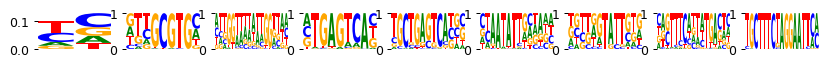

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.80it/s]


Current time: 2024-06-11 01:12:55.800547
	Loss: 219.624 , R2: 0.003
	Training time (model/function): (3.974s / 3.974s)
		per epoch (model/function): (0.284s/ 0.284s)
		per 1k samples: 0.108s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9862833422514504, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 50

### next filter to optimize 50 

FREEZING KERNELS
optimizing feature type mono
next kernels {50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.89it/s]


Current time: 2024-06-11 01:13:00.245263
	Loss: 182.075 , R2: 0.004
	Training time (model/function): (7.857s / 3.884s)
		per epoch (model/function): (0.561s/ 0.277s)
		per 1k samples: 0.106s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9862833422514504, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.01it/s]


Current time: 2024-06-11 01:13:04.514426
	Loss: 160.064 , R2: 0.004
	Training time (model/function): (11.632s / 3.774s)
		per epoch (model/function): (0.831s/ 0.270s)
		per 1k samples: 0.103s
best loss 160.064
last five r2 values, by sequential filter optimization: ['0.004']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9862833422514504, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 100

### next filter to optimize 100 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.82it/s]


Current time: 2024-06-11 01:13:09.458126
	Loss: 155.388 , R2: 0.005
	Training time (model/function): (15.595s / 3.963s)
		per epoch (model/function): (1.114s/ 0.283s)
		per 1k samples: 0.108s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9862833422514504, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.01it/s]


Current time: 2024-06-11 01:13:13.791880
	Loss: 147.734 , R2: 0.005
	Training time (model/function): (19.364s / 3.769s)
		per epoch (model/function): (1.383s/ 0.269s)
		per 1k samples: 0.102s
best loss 147.734
last five r2 values, by sequential filter optimization: ['0.004', '0.005']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9862833422514504, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 150

### next filter to optimize 150 

FREEZING KERNELS
optimizing feature type mono
next kernels {150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.90it/s]


Current time: 2024-06-11 01:13:18.643885
	Loss: 149.722 , R2: 0.005
	Training time (model/function): (23.246s / 3.882s)
		per epoch (model/function): (1.660s/ 0.277s)
		per 1k samples: 0.105s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9862833422514504, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.92it/s]


Current time: 2024-06-11 01:13:23.006355
	Loss: 145.142 , R2: 0.005
	Training time (model/function): (27.101s / 3.855s)
		per epoch (model/function): (1.936s/ 0.275s)
		per 1k samples: 0.105s
best loss 145.142
last five r2 values, by sequential filter optimization: ['0.004', '0.005', '0.005']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9862833422514504, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 200

### next filter to optimize 200 

FREEZING KERNELS
optimizing feature type mono
next kernels {200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.82it/s]


Current time: 2024-06-11 01:13:27.947844
	Loss: 148.526 , R2: 0.005
	Training time (model/function): (31.063s / 3.962s)
		per epoch (model/function): (2.219s/ 0.283s)
		per 1k samples: 0.108s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9862833422514504, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.04it/s]


Current time: 2024-06-11 01:13:32.264295
	Loss: 144.599 , R2: 0.005
	Training time (model/function): (34.811s / 3.749s)
		per epoch (model/function): (2.487s/ 0.268s)
		per 1k samples: 0.102s
best loss 144.599
last five r2 values, by sequential filter optimization: ['0.004', '0.005', '0.005', '0.005']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9862833422514504, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 250

### next filter to optimize 250 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.88it/s]


Current time: 2024-06-11 01:13:37.214397
	Loss: 148.270 , R2: 0.005
	Training time (model/function): (38.709s / 3.897s)
		per epoch (model/function): (2.765s/ 0.278s)
		per 1k samples: 0.106s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9862833422514504, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.01it/s]


Current time: 2024-06-11 01:13:41.483903
	Loss: 144.485 , R2: 0.005
	Training time (model/function): (42.485s / 3.776s)
		per epoch (model/function): (3.035s/ 0.270s)
		per 1k samples: 0.103s
best loss 144.485
last five r2 values, by sequential filter optimization: ['0.004', '0.005', '0.005', '0.005', '0.005']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9862833422514504, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 42.48482823371887s
Time per epoch (total): 0.010 s
saving model...
True /home/ilibarra/workspace/theislab/mubind/data/pbmc/episcanpy/mubind_output/obs1000/pwms/running_time.pkl
/home/ilibarra/workspace/theislab/mubind/data/pbmc/random/processed_laura_2023_obs1000_var3000.h5ad
pbmc (1000, 3000)
False /home/ilibarra/workspace/theislab/mubind/data/pbmc/random/mubind_output/obs1000/pwms/model.pt
False /home/ilibarra/workspace/theislab/mubind/data/pbmc/ran

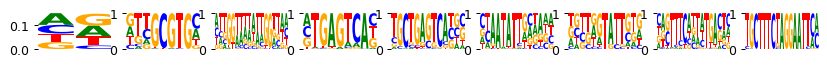

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.79it/s]


Current time: 2024-06-11 01:13:54.005930
	Loss: 219.808 , R2: 0.315
	Training time (model/function): (3.991s / 3.991s)
		per epoch (model/function): (0.285s/ 0.285s)
		per 1k samples: 0.106s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9982487478363048, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 50

### next filter to optimize 50 

FREEZING KERNELS
optimizing feature type mono
next kernels {50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.79it/s]


Current time: 2024-06-11 01:13:58.491313
	Loss: 182.262 , R2: 0.317
	Training time (model/function): (7.981s / 3.990s)
		per epoch (model/function): (0.570s/ 0.285s)
		per 1k samples: 0.106s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9982487478363048, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.89it/s]


Current time: 2024-06-11 01:14:02.946987
	Loss: 160.250 , R2: 0.317
	Training time (model/function): (11.868s / 3.887s)
		per epoch (model/function): (0.848s/ 0.278s)
		per 1k samples: 0.103s
best loss 160.250
last five r2 values, by sequential filter optimization: ['0.317']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9982487478363048, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 100

### next filter to optimize 100 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.75it/s]


Current time: 2024-06-11 01:14:07.951308
	Loss: 155.577 , R2: 0.318
	Training time (model/function): (15.893s / 4.026s)
		per epoch (model/function): (1.135s/ 0.288s)
		per 1k samples: 0.107s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9982487478363048, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.78it/s]


Current time: 2024-06-11 01:14:12.446274
	Loss: 147.922 , R2: 0.318
	Training time (model/function): (19.891s / 3.998s)
		per epoch (model/function): (1.421s/ 0.286s)
		per 1k samples: 0.106s
best loss 147.922
last five r2 values, by sequential filter optimization: ['0.317', '0.318']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9982487478363048, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 150

### next filter to optimize 150 

FREEZING KERNELS
optimizing feature type mono
next kernels {150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.70it/s]


Current time: 2024-06-11 01:14:17.520561
	Loss: 149.912 , R2: 0.319
	Training time (model/function): (23.973s / 4.081s)
		per epoch (model/function): (1.712s/ 0.292s)
		per 1k samples: 0.108s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9982487478363048, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.85it/s]


Current time: 2024-06-11 01:14:22.038827
	Loss: 145.329 , R2: 0.319
	Training time (model/function): (27.898s / 3.925s)
		per epoch (model/function): (1.993s/ 0.280s)
		per 1k samples: 0.104s
best loss 145.329
last five r2 values, by sequential filter optimization: ['0.317', '0.318', '0.319']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9982487478363048, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 200

### next filter to optimize 200 

FREEZING KERNELS
optimizing feature type mono
next kernels {200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.76it/s]


Current time: 2024-06-11 01:14:27.128073
	Loss: 148.708 , R2: 0.320
	Training time (model/function): (31.917s / 4.019s)
		per epoch (model/function): (2.280s/ 0.287s)
		per 1k samples: 0.106s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9982487478363048, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.89it/s]


Current time: 2024-06-11 01:14:31.506594
	Loss: 144.787 , R2: 0.319
	Training time (model/function): (35.801s / 3.885s)
		per epoch (model/function): (2.557s/ 0.277s)
		per 1k samples: 0.103s
best loss 144.787
last five r2 values, by sequential filter optimization: ['0.317', '0.318', '0.319', '0.319']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9982487478363048, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 250

### next filter to optimize 250 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.76it/s]


Current time: 2024-06-11 01:14:36.566423
	Loss: 148.467 , R2: 0.321
	Training time (model/function): (39.888s / 4.087s)
		per epoch (model/function): (2.849s/ 0.292s)
		per 1k samples: 0.108s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9982487478363048, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.84it/s]


Current time: 2024-06-11 01:14:41.079820
	Loss: 144.673 , R2: 0.321
	Training time (model/function): (43.823s / 3.935s)
		per epoch (model/function): (3.130s/ 0.281s)
		per 1k samples: 0.104s
best loss 144.670
last five r2 values, by sequential filter optimization: ['0.317', '0.318', '0.319', '0.319', '0.321']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9982487478363048, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 43.82274270057678s
Time per epoch (total): 0.010 s
saving model...
True /home/ilibarra/workspace/theislab/mubind/data/pbmc/random/mubind_output/obs1000/pwms/running_time.pkl
/home/ilibarra/workspace/theislab/mubind/data/pbmc/random/processed_laura_2023_obs2000_var6000.h5ad
pbmc (2000, 5999)
False /home/ilibarra/workspace/theislab/mubind/data/pbmc/random/mubind_output/obs2000/pwms/model.pt
False /home/ilibarra/workspace/theislab/mubind/data/pbmc/random

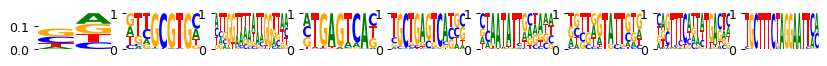

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.48it/s]


Current time: 2024-06-11 01:15:03.203615
	Loss: 188.720 , R2: 0.305
	Training time (model/function): (10.452s / 10.452s)
		per epoch (model/function): (0.747s/ 0.747s)
		per 1k samples: 0.138s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9988039684122896, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 50

### next filter to optimize 50 

FREEZING KERNELS
optimizing feature type mono
next kernels {50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.49it/s]


Current time: 2024-06-11 01:15:14.922345
	Loss: 159.990 , R2: 0.307
	Training time (model/function): (20.630s / 10.179s)
		per epoch (model/function): (1.474s/ 0.727s)
		per 1k samples: 0.135s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9988039684122896, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.48it/s]


Current time: 2024-06-11 01:15:26.732566
	Loss: 147.973 , R2: 0.307
	Training time (model/function): (30.928s / 10.298s)
		per epoch (model/function): (2.209s/ 0.736s)
		per 1k samples: 0.136s
best loss 147.973
last five r2 values, by sequential filter optimization: ['0.307']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9988039684122896, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 100

### next filter to optimize 100 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.50it/s]


Current time: 2024-06-11 01:15:39.839731
	Loss: 149.376 , R2: 0.308
	Training time (model/function): (41.064s / 10.135s)
		per epoch (model/function): (2.933s/ 0.724s)
		per 1k samples: 0.134s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9988039684122896, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.46it/s]


Current time: 2024-06-11 01:15:51.666575
	Loss: 144.918 , R2: 0.309
	Training time (model/function): (51.485s / 10.421s)
		per epoch (model/function): (3.677s/ 0.744s)
		per 1k samples: 0.138s
best loss 144.918
last five r2 values, by sequential filter optimization: ['0.307', '0.309']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9988039684122896, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 150

### next filter to optimize 150 

FREEZING KERNELS
optimizing feature type mono
next kernels {150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.54it/s]


Current time: 2024-06-11 01:16:04.602687
	Loss: 148.487 , R2: 0.309
	Training time (model/function): (61.383s / 9.898s)
		per epoch (model/function): (4.384s/ 0.707s)
		per 1k samples: 0.131s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9988039684122896, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.48it/s]


Current time: 2024-06-11 01:16:16.458611
	Loss: 144.664 , R2: 0.309
	Training time (model/function): (71.669s / 10.286s)
		per epoch (model/function): (5.119s/ 0.735s)
		per 1k samples: 0.136s
best loss 144.664
last five r2 values, by sequential filter optimization: ['0.307', '0.309', '0.309']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9988039684122896, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 200

### next filter to optimize 200 

FREEZING KERNELS
optimizing feature type mono
next kernels {200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.46it/s]


Current time: 2024-06-11 01:16:29.915590
	Loss: 148.404 , R2: 0.309
	Training time (model/function): (82.090s / 10.421s)
		per epoch (model/function): (5.864s/ 0.744s)
		per 1k samples: 0.138s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9988039684122896, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.46it/s]


Current time: 2024-06-11 01:16:41.906797
	Loss: 144.643 , R2: 0.309
	Training time (model/function): (92.523s / 10.432s)
		per epoch (model/function): (6.609s/ 0.745s)
		per 1k samples: 0.138s
best loss 144.642
last five r2 values, by sequential filter optimization: ['0.307', '0.309', '0.309', '0.308']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9988039684122896, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 250

### next filter to optimize 250 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.46it/s]


Current time: 2024-06-11 01:16:55.392868
	Loss: 148.395 , R2: 0.310
	Training time (model/function): (102.902s / 10.379s)
		per epoch (model/function): (7.350s/ 0.741s)
		per 1k samples: 0.137s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9988039684122896, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.45it/s]


Current time: 2024-06-11 01:17:07.362357
	Loss: 144.641 , R2: 0.310
	Training time (model/function): (113.363s / 10.461s)
		per epoch (model/function): (8.097s/ 0.747s)
		per 1k samples: 0.138s
best loss 144.640
last five r2 values, by sequential filter optimization: ['0.307', '0.309', '0.309', '0.308', '0.310']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9988039684122896, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 113.36275219917297s
Time per epoch (total): 0.026 s
saving model...
True /home/ilibarra/workspace/theislab/mubind/data/pbmc/random/mubind_output/obs2000/pwms/running_time.pkl
/home/ilibarra/workspace/theislab/mubind/data/pbmc/episcanpy/processed_laura_2023_obs2000_var6000.h5ad
pbmc (2000, 5991)
False /home/ilibarra/workspace/theislab/mubind/data/pbmc/episcanpy/mubind_output/obs2000/pwms/model.pt
False /home/ilibarra/workspace/theislab/mubind/data/pb

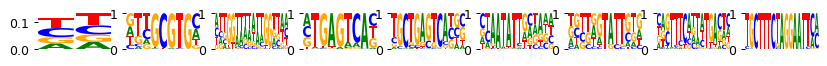

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.69it/s]


Current time: 2024-06-11 01:17:39.568974
	Loss: 188.542 , R2: 0.005
	Training time (model/function): (9.012s / 9.012s)
		per epoch (model/function): (0.644s/ 0.644s)
		per 1k samples: 0.119s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991951747324879, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 50

### next filter to optimize 50 

FREEZING KERNELS
optimizing feature type mono
next kernels {50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.68it/s]


Current time: 2024-06-11 01:17:50.059083
	Loss: 159.813 , R2: 0.005
	Training time (model/function): (18.080s / 9.068s)
		per epoch (model/function): (1.291s/ 0.648s)
		per 1k samples: 0.120s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991951747324879, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.61it/s]


Current time: 2024-06-11 01:18:00.915901
	Loss: 147.796 , R2: 0.005
	Training time (model/function): (27.496s / 9.416s)
		per epoch (model/function): (1.964s/ 0.673s)
		per 1k samples: 0.125s
best loss 147.796
last five r2 values, by sequential filter optimization: ['0.005']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991951747324879, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 100

### next filter to optimize 100 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.66it/s]


Current time: 2024-06-11 01:18:12.846955
	Loss: 149.199 , R2: 0.006
	Training time (model/function): (36.671s / 9.175s)
		per epoch (model/function): (2.619s/ 0.655s)
		per 1k samples: 0.122s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991951747324879, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.64it/s]


Current time: 2024-06-11 01:18:23.515243
	Loss: 144.741 , R2: 0.006
	Training time (model/function): (45.923s / 9.252s)
		per epoch (model/function): (3.280s/ 0.661s)
		per 1k samples: 0.123s
best loss 144.741
last five r2 values, by sequential filter optimization: ['0.005', '0.006']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991951747324879, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 150

### next filter to optimize 150 

FREEZING KERNELS
optimizing feature type mono
next kernels {150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.68it/s]


Current time: 2024-06-11 01:18:35.442095
	Loss: 148.308 , R2: 0.006
	Training time (model/function): (54.980s / 9.057s)
		per epoch (model/function): (3.927s/ 0.647s)
		per 1k samples: 0.120s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991951747324879, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.65it/s]


Current time: 2024-06-11 01:18:46.080567
	Loss: 144.487 , R2: 0.006
	Training time (model/function): (64.207s / 9.227s)
		per epoch (model/function): (4.586s/ 0.659s)
		per 1k samples: 0.122s
best loss 144.487
last five r2 values, by sequential filter optimization: ['0.005', '0.006', '0.006']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991951747324879, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 200

### next filter to optimize 200 

FREEZING KERNELS
optimizing feature type mono
next kernels {200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.67it/s]


Current time: 2024-06-11 01:18:58.027049
	Loss: 148.225 , R2: 0.006
	Training time (model/function): (73.322s / 9.116s)
		per epoch (model/function): (5.237s/ 0.651s)
		per 1k samples: 0.121s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991951747324879, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.66it/s]


Current time: 2024-06-11 01:19:08.592147
	Loss: 144.466 , R2: 0.006
	Training time (model/function): (82.462s / 9.140s)
		per epoch (model/function): (5.890s/ 0.653s)
		per 1k samples: 0.121s
best loss 144.466
last five r2 values, by sequential filter optimization: ['0.005', '0.006', '0.006', '0.006']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991951747324879, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 250

### next filter to optimize 250 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.68it/s]


Current time: 2024-06-11 01:19:20.490634
	Loss: 148.214 , R2: 0.006
	Training time (model/function): (91.534s / 9.072s)
		per epoch (model/function): (6.538s/ 0.648s)
		per 1k samples: 0.120s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991951747324879, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.65it/s]


Current time: 2024-06-11 01:19:31.117159
	Loss: 144.465 , R2: 0.006
	Training time (model/function): (100.736s / 9.201s)
		per epoch (model/function): (7.195s/ 0.657s)
		per 1k samples: 0.122s
best loss 144.465
last five r2 values, by sequential filter optimization: ['0.005', '0.006', '0.006', '0.006', '0.006']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991951747324879, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 100.73562479019165s
Time per epoch (total): 0.023 s
saving model...
True /home/ilibarra/workspace/theislab/mubind/data/pbmc/episcanpy/mubind_output/obs2000/pwms/running_time.pkl
/home/ilibarra/workspace/theislab/mubind/data/organoids_treutlein_dataset/RNA_ATAC_metacells_sce_peaks_obs2000_var4000.h5ad
pbmc (2000, 4000)
False /home/ilibarra/workspace/theislab/mubind/data/organoids_treutlein_dataset/mubind_output/obs2000/pwms/model.pt
False /home/ilibar

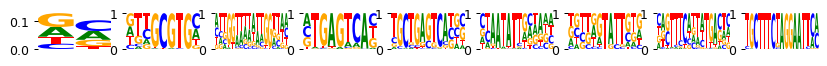

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.17it/s]


Current time: 2024-06-11 01:19:59.232550
	Loss: 211.417 , R2: 0.005
	Training time (model/function): (6.990s / 6.990s)
		per epoch (model/function): (0.499s/ 0.499s)
		per 1k samples: 0.141s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9944891207767607, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 50

### next filter to optimize 50 

FREEZING KERNELS
optimizing feature type mono
next kernels {50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.15it/s]


Current time: 2024-06-11 01:20:07.465474
	Loss: 174.860 , R2: 0.008
	Training time (model/function): (14.026s / 7.036s)
		per epoch (model/function): (1.002s/ 0.503s)
		per 1k samples: 0.142s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9944891207767607, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.85it/s]


Current time: 2024-06-11 01:20:13.929064
	Loss: 155.486 , R2: 0.008
	Training time (model/function): (19.380s / 5.355s)
		per epoch (model/function): (1.384s/ 0.382s)
		per 1k samples: 0.108s
best loss 155.486
last five r2 values, by sequential filter optimization: ['0.008']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9944891207767607, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 100

### next filter to optimize 100 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.91it/s]


Current time: 2024-06-11 01:20:21.285518
	Loss: 152.785 , R2: 0.009
	Training time (model/function): (24.589s / 5.209s)
		per epoch (model/function): (1.756s/ 0.372s)
		per 1k samples: 0.105s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9944891207767607, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.82it/s]


Current time: 2024-06-11 01:20:27.803418
	Loss: 146.333 , R2: 0.009
	Training time (model/function): (29.967s / 5.378s)
		per epoch (model/function): (2.141s/ 0.384s)
		per 1k samples: 0.108s
best loss 146.333
last five r2 values, by sequential filter optimization: ['0.008', '0.009']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9944891207767607, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 150

### next filter to optimize 150 

FREEZING KERNELS
optimizing feature type mono
next kernels {150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.85it/s]


Current time: 2024-06-11 01:20:35.315956
	Loss: 148.993 , R2: 0.010
	Training time (model/function): (35.299s / 5.331s)
		per epoch (model/function): (2.521s/ 0.381s)
		per 1k samples: 0.108s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9944891207767607, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.81it/s]


Current time: 2024-06-11 01:20:41.847997
	Loss: 144.771 , R2: 0.010
	Training time (model/function): (40.711s / 5.412s)
		per epoch (model/function): (2.908s/ 0.387s)
		per 1k samples: 0.109s
best loss 144.771
last five r2 values, by sequential filter optimization: ['0.008', '0.009', '0.010']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9944891207767607, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 200

### next filter to optimize 200 

FREEZING KERNELS
optimizing feature type mono
next kernels {200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.90it/s]


Current time: 2024-06-11 01:20:49.306522
	Loss: 148.338 , R2: 0.010
	Training time (model/function): (45.955s / 5.244s)
		per epoch (model/function): (3.283s/ 0.375s)
		per 1k samples: 0.106s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9944891207767607, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.87it/s]


Current time: 2024-06-11 01:20:55.657492
	Loss: 144.504 , R2: 0.010
	Training time (model/function): (51.264s / 5.309s)
		per epoch (model/function): (3.662s/ 0.379s)
		per 1k samples: 0.107s
best loss 144.504
last five r2 values, by sequential filter optimization: ['0.008', '0.009', '0.010', '0.010']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9944891207767607, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 250

### next filter to optimize 250 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.89it/s]


Current time: 2024-06-11 01:21:03.136043
	Loss: 148.227 , R2: 0.010
	Training time (model/function): (56.537s / 5.273s)
		per epoch (model/function): (4.038s/ 0.377s)
		per 1k samples: 0.106s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9944891207767607, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.80it/s]


Current time: 2024-06-11 01:21:09.612589
	Loss: 144.459 , R2: 0.011
	Training time (model/function): (61.974s / 5.437s)
		per epoch (model/function): (4.427s/ 0.388s)
		per 1k samples: 0.110s
best loss 144.459
last five r2 values, by sequential filter optimization: ['0.008', '0.009', '0.010', '0.010', '0.011']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9944891207767607, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 61.974201917648315s
Time per epoch (total): 0.014 s
saving model...
True /home/ilibarra/workspace/theislab/mubind/data/organoids_treutlein_dataset/mubind_output/obs2000/pwms/running_time.pkl
/home/ilibarra/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/episcanpy/pancreas_multiome_2022_processed_atac_obs2000_var6000.h5ad
pbmc (2000, 6000)
False /home/ilibarra/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/episcanpy/mubind_output

Feature (chr13:114815403-114816207) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:115013744-115014435) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:115132176-115133017) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:115352180-115352554) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:115352911-115353432) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:115630640-115631197) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:115725170-115726093) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:115765072-115765950) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:115830779-115831579) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:116049178-116050125) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:116577317-116578225) beyond the len

preparing sequences test...
/tmp/tmpuh1sk864
genome hg19 False
/home/ilibarra/annotations/hg38/genome/hg38.fa
True /home/ilibarra/annotations/hg38/genome/hg38.fa
running bedtools...
['bedtools', 'getfasta', '-fi', '/home/ilibarra/annotations/hg38/genome/hg38.fa', '-bed', '/tmp/tmpuh1sk864', '-fo', '/tmp/tmpzxobpycn']
bedtools getfasta -fi /home/ilibarra/annotations/hg38/genome/hg38.fa -bed /tmp/tmpuh1sk864 -fo /tmp/tmpzxobpycn
(2000, 5245) (2000, 296)
sum of reads 50015.0
(5245, 2001)
# cells 2000
# peaks 5245
selected (5241, 2000)
(296, 2001)
# cells 2000
# peaks 296
selected (296, 2000)
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,

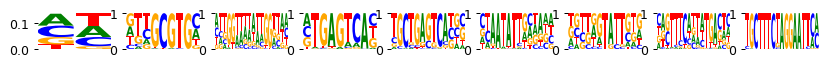

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.85it/s]


Current time: 2024-06-11 01:21:35.603807
	Loss: 188.545 , R2: 0.002
	Training time (model/function): (8.208s / 8.208s)
		per epoch (model/function): (0.586s/ 0.586s)
		per 1k samples: 0.112s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9979044596253678, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 50

### next filter to optimize 50 

FREEZING KERNELS
optimizing feature type mono
next kernels {50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.84it/s]


Current time: 2024-06-11 01:21:46.247292
	Loss: 159.815 , R2: 0.002
	Training time (model/function): (16.447s / 8.239s)
		per epoch (model/function): (1.175s/ 0.589s)
		per 1k samples: 0.112s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9979044596253678, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.81it/s]


Current time: 2024-06-11 01:21:56.945342
	Loss: 147.799 , R2: 0.002
	Training time (model/function): (24.849s / 8.402s)
		per epoch (model/function): (1.775s/ 0.600s)
		per 1k samples: 0.115s
best loss 147.799
last five r2 values, by sequential filter optimization: ['0.002']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9979044596253678, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 100

### next filter to optimize 100 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.84it/s]


Current time: 2024-06-11 01:22:09.877682
	Loss: 149.201 , R2: 0.002
	Training time (model/function): (33.087s / 8.238s)
		per epoch (model/function): (2.363s/ 0.588s)
		per 1k samples: 0.112s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9979044596253678, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.81it/s]


Current time: 2024-06-11 01:22:20.590417
	Loss: 144.744 , R2: 0.002
	Training time (model/function): (41.481s / 8.394s)
		per epoch (model/function): (2.963s/ 0.600s)
		per 1k samples: 0.114s
best loss 144.744
last five r2 values, by sequential filter optimization: ['0.002', '0.002']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9979044596253678, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 150

### next filter to optimize 150 

FREEZING KERNELS
optimizing feature type mono
next kernels {150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.84it/s]


Current time: 2024-06-11 01:22:33.412054
	Loss: 148.311 , R2: 0.002
	Training time (model/function): (49.722s / 8.241s)
		per epoch (model/function): (3.552s/ 0.589s)
		per 1k samples: 0.112s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9979044596253678, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.83it/s]


Current time: 2024-06-11 01:22:44.096190
	Loss: 144.490 , R2: 0.002
	Training time (model/function): (58.035s / 8.313s)
		per epoch (model/function): (4.145s/ 0.594s)
		per 1k samples: 0.113s
best loss 144.490
last five r2 values, by sequential filter optimization: ['0.002', '0.002', '0.002']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9979044596253678, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 200

### next filter to optimize 200 

FREEZING KERNELS
optimizing feature type mono
next kernels {200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.85it/s]


Current time: 2024-06-11 01:22:56.964212
	Loss: 148.228 , R2: 0.002
	Training time (model/function): (66.226s / 8.191s)
		per epoch (model/function): (4.730s/ 0.585s)
		per 1k samples: 0.112s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9979044596253678, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.84it/s]


Current time: 2024-06-11 01:23:07.513039
	Loss: 144.469 , R2: 0.002
	Training time (model/function): (74.478s / 8.252s)
		per epoch (model/function): (5.320s/ 0.589s)
		per 1k samples: 0.112s
best loss 144.469
last five r2 values, by sequential filter optimization: ['0.002', '0.002', '0.002', '0.002']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9979044596253678, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 250

### next filter to optimize 250 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.86it/s]


Current time: 2024-06-11 01:23:20.410300
	Loss: 148.213 , R2: 0.002
	Training time (model/function): (82.631s / 8.153s)
		per epoch (model/function): (5.902s/ 0.582s)
		per 1k samples: 0.111s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9979044596253678, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.85it/s]


Current time: 2024-06-11 01:23:31.008776
	Loss: 144.467 , R2: 0.002
	Training time (model/function): (90.836s / 8.206s)
		per epoch (model/function): (6.488s/ 0.586s)
		per 1k samples: 0.112s
best loss 144.467
last five r2 values, by sequential filter optimization: ['0.002', '0.002', '0.002', '0.002', '0.002']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9979044596253678, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 90.83632445335388s
Time per epoch (total): 0.021 s
saving model...
True /home/ilibarra/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/episcanpy/mubind_output/obs2000/pwms/running_time.pkl
/home/ilibarra/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/random/pancreas_multiome_2022_processed_atac_obs2000_var6000.h5ad
pbmc (2000, 6000)
False /home/ilibarra/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/random/mubind_out

Feature (chr13:116170092-116170851) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:116335498-116336407) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:117305814-117306649) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:117590336-117591207) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:118041406-118042347) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:118057367-118057901) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:119404892-119405768) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:119426244-119426790) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:119961543-119962499) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr14:108198859-108199799) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:108334612-108335517) beyond the len

preparing sequences test...
/tmp/tmpnue1u29y
genome hg19 False
/home/ilibarra/annotations/hg38/genome/hg38.fa
True /home/ilibarra/annotations/hg38/genome/hg38.fa
running bedtools...
['bedtools', 'getfasta', '-fi', '/home/ilibarra/annotations/hg38/genome/hg38.fa', '-bed', '/tmp/tmpnue1u29y', '-fo', '/tmp/tmpypcc8rv1']
bedtools getfasta -fi /home/ilibarra/annotations/hg38/genome/hg38.fa -bed /tmp/tmpnue1u29y -fo /tmp/tmpypcc8rv1
(2000, 5268) (2000, 297)
sum of reads 816933.0
(5268, 2001)
# cells 2000
# peaks 5268
selected (5268, 2000)
(297, 2001)
# cells 2000
# peaks 297
selected (297, 2000)
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15

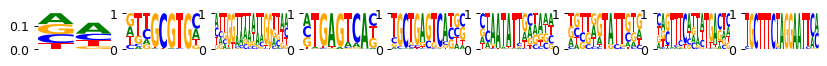

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:21<00:00,  1.41s/it]


Current time: 2024-06-11 01:24:28.162619
	Loss: 188.698 , R2: 0.332
	Training time (model/function): (21.649s / 21.649s)
		per epoch (model/function): (1.546s/ 1.546s)
		per 1k samples: 0.294s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9987425467609173, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 50

### next filter to optimize 50 

FREEZING KERNELS
optimizing feature type mono
next kernels {50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:20<00:00,  1.34s/it]


Current time: 2024-06-11 01:24:55.592861
	Loss: 159.970 , R2: 0.333
	Training time (model/function): (42.301s / 20.652s)
		per epoch (model/function): (3.022s/ 1.475s)
		per 1k samples: 0.280s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9987425467609173, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:20<00:00,  1.39s/it]


Current time: 2024-06-11 01:25:22.746979
	Loss: 147.953 , R2: 0.333
	Training time (model/function): (63.355s / 21.053s)
		per epoch (model/function): (4.525s/ 1.504s)
		per 1k samples: 0.285s
best loss 147.953
last five r2 values, by sequential filter optimization: ['0.333']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9987425467609173, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 100

### next filter to optimize 100 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:21<00:00,  1.45s/it]


Current time: 2024-06-11 01:25:58.677318
	Loss: 149.356 , R2: 0.334
	Training time (model/function): (85.622s / 22.267s)
		per epoch (model/function): (6.116s/ 1.591s)
		per 1k samples: 0.302s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9987425467609173, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:20<00:00,  1.38s/it]


Current time: 2024-06-11 01:26:26.876775
	Loss: 144.897 , R2: 0.334
	Training time (model/function): (106.570s / 20.948s)
		per epoch (model/function): (7.612s/ 1.496s)
		per 1k samples: 0.284s
best loss 144.897
last five r2 values, by sequential filter optimization: ['0.333', '0.334']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9987425467609173, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 150

### next filter to optimize 150 

FREEZING KERNELS
optimizing feature type mono
next kernels {150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:21<00:00,  1.45s/it]


Current time: 2024-06-11 01:27:03.269432
	Loss: 148.465 , R2: 0.334
	Training time (model/function): (128.523s / 21.953s)
		per epoch (model/function): (9.180s/ 1.568s)
		per 1k samples: 0.298s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9987425467609173, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:20<00:00,  1.36s/it]


Current time: 2024-06-11 01:27:31.383542
	Loss: 144.645 , R2: 0.334
	Training time (model/function): (149.217s / 20.694s)
		per epoch (model/function): (10.658s/ 1.478s)
		per 1k samples: 0.281s
best loss 144.645
last five r2 values, by sequential filter optimization: ['0.333', '0.334', '0.334']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9987425467609173, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 200

### next filter to optimize 200 

FREEZING KERNELS
optimizing feature type mono
next kernels {200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:21<00:00,  1.40s/it]


Current time: 2024-06-11 01:28:01.932180
	Loss: 148.380 , R2: 0.335
	Training time (model/function): (170.610s / 21.393s)
		per epoch (model/function): (12.186s/ 1.528s)
		per 1k samples: 0.290s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9987425467609173, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.59it/s]


Current time: 2024-06-11 01:28:13.985363
	Loss: 144.624 , R2: 0.336
	Training time (model/function): (180.160s / 9.550s)
		per epoch (model/function): (12.869s/ 0.682s)
		per 1k samples: 0.129s
best loss 144.622
last five r2 values, by sequential filter optimization: ['0.333', '0.334', '0.334', '0.336']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9987425467609173, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 250

### next filter to optimize 250 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.60it/s]


Current time: 2024-06-11 01:28:28.434191
	Loss: 148.372 , R2: 0.336
	Training time (model/function): (189.653s / 9.493s)
		per epoch (model/function): (13.547s/ 0.678s)
		per 1k samples: 0.129s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9987425467609173, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.59it/s]


Current time: 2024-06-11 01:28:40.486086
	Loss: 144.621 , R2: 0.336
	Training time (model/function): (199.222s / 9.569s)
		per epoch (model/function): (14.230s/ 0.683s)
		per 1k samples: 0.130s
best loss 144.619
last five r2 values, by sequential filter optimization: ['0.333', '0.334', '0.334', '0.336', '0.336']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9987425467609173, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 199.22202730178833s
Time per epoch (total): 0.046 s
saving model...
True /home/ilibarra/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/random/mubind_output/obs2000/pwms/running_time.pkl
/home/ilibarra/workspace/theislab/mubind/data/noack_2022/random/merged_scATAC_integrated_cicero_faye_chong_obs2000_var6000.h5ad
pbmc (2000, 6000)
False /home/ilibarra/workspace/theislab/mubind/data/noack_2022/random/mubind_output/obs2000/pwms/model.pt
Fal

Feature (chr13:114891991-114892491) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:115132365-115132865) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:117143207-117143707) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:118763188-118763688) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:119649387-119649887) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr14:108797439-108797939) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:111995177-111995677) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:114121127-114121627) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:114433677-114434177) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:115042642-115043142) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:115093107-115093607) beyond the len

preparing sequences test...
/tmp/tmpw0xfgnr6
genome hg19 False
/home/ilibarra/annotations/hg38/genome/hg38.fa
True /home/ilibarra/annotations/hg38/genome/hg38.fa
running bedtools...
['bedtools', 'getfasta', '-fi', '/home/ilibarra/annotations/hg38/genome/hg38.fa', '-bed', '/tmp/tmpw0xfgnr6', '-fo', '/tmp/tmpc4xpqwax']
bedtools getfasta -fi /home/ilibarra/annotations/hg38/genome/hg38.fa -bed /tmp/tmpw0xfgnr6 -fo /tmp/tmpc4xpqwax
(2000, 5260) (2000, 289)
sum of reads 742304.0
(5260, 2001)
# cells 2000
# peaks 5260
selected (5260, 2000)
(289, 2001)
# cells 2000
# peaks 289
selected (289, 2000)
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15

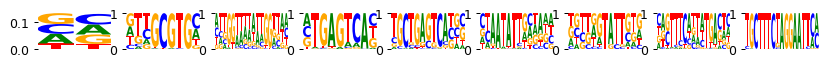

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.31it/s]


Current time: 2024-06-11 01:29:15.518837
	Loss: 188.724 , R2: 0.171
	Training time (model/function): (6.563s / 6.563s)
		per epoch (model/function): (0.469s/ 0.469s)
		per 1k samples: 0.089s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9983448067989839, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 50

### next filter to optimize 50 

FREEZING KERNELS
optimizing feature type mono
next kernels {50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:12<00:00,  1.20it/s]


Current time: 2024-06-11 01:29:30.514774
	Loss: 159.994 , R2: 0.172
	Training time (model/function): (19.266s / 12.703s)
		per epoch (model/function): (1.376s/ 0.907s)
		per 1k samples: 0.172s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9983448067989839, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.31it/s]


Current time: 2024-06-11 01:29:39.379292
	Loss: 147.979 , R2: 0.172
	Training time (model/function): (25.842s / 6.577s)
		per epoch (model/function): (1.846s/ 0.470s)
		per 1k samples: 0.089s
best loss 147.979
last five r2 values, by sequential filter optimization: ['0.172']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9983448067989839, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 100

### next filter to optimize 100 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.32it/s]


Current time: 2024-06-11 01:29:50.247593
	Loss: 149.380 , R2: 0.172
	Training time (model/function): (32.395s / 6.553s)
		per epoch (model/function): (2.314s/ 0.468s)
		per 1k samples: 0.089s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9983448067989839, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.29it/s]


Current time: 2024-06-11 01:29:59.134898
	Loss: 144.921 , R2: 0.172
	Training time (model/function): (39.034s / 6.638s)
		per epoch (model/function): (2.788s/ 0.474s)
		per 1k samples: 0.090s
best loss 144.921
last five r2 values, by sequential filter optimization: ['0.172', '0.172']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9983448067989839, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 150

### next filter to optimize 150 

FREEZING KERNELS
optimizing feature type mono
next kernels {150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.41it/s]


Current time: 2024-06-11 01:30:14.462167
	Loss: 148.488 , R2: 0.172
	Training time (model/function): (49.953s / 10.919s)
		per epoch (model/function): (3.568s/ 0.780s)
		per 1k samples: 0.148s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9983448067989839, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.33it/s]


Current time: 2024-06-11 01:30:23.227867
	Loss: 144.670 , R2: 0.173
	Training time (model/function): (56.459s / 6.505s)
		per epoch (model/function): (4.033s/ 0.465s)
		per 1k samples: 0.088s
best loss 144.670
last five r2 values, by sequential filter optimization: ['0.172', '0.172', '0.173']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9983448067989839, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 200

### next filter to optimize 200 

FREEZING KERNELS
optimizing feature type mono
next kernels {200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.37it/s]


Current time: 2024-06-11 01:30:34.128151
	Loss: 148.413 , R2: 0.173
	Training time (model/function): (62.877s / 6.418s)
		per epoch (model/function): (4.491s/ 0.458s)
		per 1k samples: 0.087s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9983448067989839, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.38it/s]


Current time: 2024-06-11 01:30:42.785264
	Loss: 144.648 , R2: 0.173
	Training time (model/function): (69.254s / 6.377s)
		per epoch (model/function): (4.947s/ 0.455s)
		per 1k samples: 0.087s
best loss 144.648
last five r2 values, by sequential filter optimization: ['0.172', '0.172', '0.173', '0.173']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9983448067989839, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 250

### next filter to optimize 250 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.38it/s]


Current time: 2024-06-11 01:30:53.666353
	Loss: 148.403 , R2: 0.173
	Training time (model/function): (75.628s / 6.375s)
		per epoch (model/function): (5.402s/ 0.455s)
		per 1k samples: 0.087s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9983448067989839, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.39it/s]


Current time: 2024-06-11 01:31:02.237735
	Loss: 144.648 , R2: 0.173
	Training time (model/function): (81.975s / 6.347s)
		per epoch (model/function): (5.855s/ 0.453s)
		per 1k samples: 0.086s
best loss 144.643
last five r2 values, by sequential filter optimization: ['0.172', '0.172', '0.173', '0.173', '0.173']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9983448067989839, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 81.97473978996277s
Time per epoch (total): 0.019 s
saving model...
True /home/ilibarra/workspace/theislab/mubind/data/noack_2022/random/mubind_output/obs2000/pwms/running_time.pkl
/home/ilibarra/workspace/theislab/mubind/data/noack_2022/episcanpy/merged_scATAC_integrated_cicero_faye_chong_obs2000_var6000.h5ad
pbmc (2000, 6000)
ad path not found. Next
/home/ilibarra/workspace/theislab/mubind/data/pbmc/random/processed_laura_2023_obs5000_var15000.h5ad
p

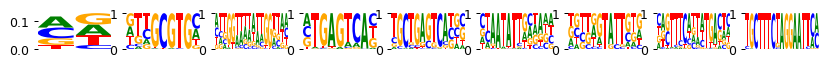

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:45<00:00,  3.02s/it]


Current time: 2024-06-11 01:32:34.517154
	Loss: 161.341 , R2: 0.311
	Training time (model/function): (46.019s / 46.019s)
		per epoch (model/function): (3.287s/ 3.287s)
		per 1k samples: 0.244s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9948854582988786, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 50

### next filter to optimize 50 

FREEZING KERNELS
optimizing feature type mono
next kernels {50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:02<00:00,  4.18s/it]


Current time: 2024-06-11 01:33:54.216510
	Loss: 149.831 , R2: 0.312
	Training time (model/function): (110.302s / 64.283s)
		per epoch (model/function): (7.879s/ 4.592s)
		per 1k samples: 0.340s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9948854582988786, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:53<00:00,  3.59s/it]


Current time: 2024-06-11 01:34:56.207970
	Loss: 144.797 , R2: 0.312
	Training time (model/function): (165.771s / 55.469s)
		per epoch (model/function): (11.841s/ 3.962s)
		per 1k samples: 0.294s
best loss 144.797
last five r2 values, by sequential filter optimization: ['0.312']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9948854582988786, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 100

### next filter to optimize 100 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:35<00:00,  2.34s/it]


Current time: 2024-06-11 01:35:44.876594
	Loss: 148.438 , R2: 0.312
	Training time (model/function): (201.516s / 35.745s)
		per epoch (model/function): (14.394s/ 2.553s)
		per 1k samples: 0.189s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9948854582988786, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:36<00:00,  2.45s/it]


Current time: 2024-06-11 01:36:28.741641
	Loss: 144.644 , R2: 0.312
	Training time (model/function): (238.927s / 37.411s)
		per epoch (model/function): (17.066s/ 2.672s)
		per 1k samples: 0.198s
best loss 144.644
last five r2 values, by sequential filter optimization: ['0.312', '0.312']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9948854582988786, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 150

### next filter to optimize 150 

FREEZING KERNELS
optimizing feature type mono
next kernels {150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:35<00:00,  2.34s/it]


Current time: 2024-06-11 01:37:17.372539
	Loss: 148.412 , R2: 0.312
	Training time (model/function): (274.665s / 35.739s)
		per epoch (model/function): (19.619s/ 2.553s)
		per 1k samples: 0.189s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9948854582988786, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:36<00:00,  2.45s/it]


Current time: 2024-06-11 01:38:01.268730
	Loss: 144.643 , R2: 0.312
	Training time (model/function): (312.101s / 37.436s)
		per epoch (model/function): (22.293s/ 2.674s)
		per 1k samples: 0.198s
best loss 144.642
last five r2 values, by sequential filter optimization: ['0.312', '0.312', '0.312']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9948854582988786, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 200

### next filter to optimize 200 

FREEZING KERNELS
optimizing feature type mono
next kernels {200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:35<00:00,  2.38s/it]


Current time: 2024-06-11 01:38:50.595879
	Loss: 148.401 , R2: 0.312
	Training time (model/function): (348.429s / 36.328s)
		per epoch (model/function): (24.888s/ 2.595s)
		per 1k samples: 0.192s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9948854582988786, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:36<00:00,  2.42s/it]


Current time: 2024-06-11 01:39:34.009614
	Loss: 144.642 , R2: 0.312
	Training time (model/function): (385.404s / 36.975s)
		per epoch (model/function): (27.529s/ 2.641s)
		per 1k samples: 0.196s
best loss 144.642
last five r2 values, by sequential filter optimization: ['0.312', '0.312', '0.312', '0.312']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9948854582988786, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 250

### next filter to optimize 250 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:35<00:00,  2.34s/it]


Current time: 2024-06-11 01:40:22.714684
	Loss: 148.397 , R2: 0.313
	Training time (model/function): (421.140s / 35.736s)
		per epoch (model/function): (30.081s/ 2.553s)
		per 1k samples: 0.189s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9948854582988786, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:36<00:00,  2.44s/it]


Current time: 2024-06-11 01:41:06.378261
	Loss: 144.643 , R2: 0.313
	Training time (model/function): (458.427s / 37.287s)
		per epoch (model/function): (32.745s/ 2.663s)
		per 1k samples: 0.197s
best loss 144.642
last five r2 values, by sequential filter optimization: ['0.312', '0.312', '0.312', '0.312', '0.313']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9948854582988786, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 458.42684745788574s
Time per epoch (total): 0.105 s
saving model...
True /home/ilibarra/workspace/theislab/mubind/data/pbmc/random/mubind_output/obs5000/pwms/running_time.pkl
/home/ilibarra/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/random/pancreas_multiome_2022_processed_atac_obs5000_var15000.h5ad
pbmc (5000, 15000)
False /home/ilibarra/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/random/mubind_output/obs5000/pwms/mod

Feature (chr13:114534361-114535282) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:114963996-114964883) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:115032858-115033733) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:116521163-116522001) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:116994273-116995205) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:117202625-117203549) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:117215149-117216035) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:117383251-117384103) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:117602013-117602890) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:118020849-118021762) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:119462308-119463180) beyond the len

preparing sequences test...
/tmp/tmp12c95ajo
genome hg19 False
/home/ilibarra/annotations/hg38/genome/hg38.fa
True /home/ilibarra/annotations/hg38/genome/hg38.fa
running bedtools...
['bedtools', 'getfasta', '-fi', '/home/ilibarra/annotations/hg38/genome/hg38.fa', '-bed', '/tmp/tmp12c95ajo', '-fo', '/tmp/tmpuqpgse1d']
bedtools getfasta -fi /home/ilibarra/annotations/hg38/genome/hg38.fa -bed /tmp/tmp12c95ajo -fo /tmp/tmpuqpgse1d
(5000, 13171) (5000, 731)
sum of reads 5215901.0


Feature (chr13:119615720-119616597) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr14:117117673-117118515) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:121588192-121588999) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr16:90374297-90375134) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr16:91512128-91513024) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr16:91832095-91832999) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr16:93140292-93141246) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr16:94872479-94873357) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr17:83924849-83925508) beyond the length of chr17 size (83257441 bp).  Skipping.
Feature (chr17:84663319-84664175) beyond the length of chr17 size (83257441 bp).  Skipping.
Feature (chr17:88484726-88485461) beyond the length of chr17 size (8325

(13171, 5001)
# cells 5000
# peaks 13171
selected (13171, 5000)
(731, 5001)
# cells 5000
# peaks 731
selected (731, 5000)
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1

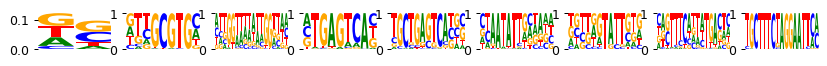

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:40<00:00,  2.68s/it]


Current time: 2024-06-11 01:43:56.176810
	Loss: 162.011 , R2: 0.317
	Training time (model/function): (41.019s / 41.019s)
		per epoch (model/function): (2.930s/ 2.930s)
		per 1k samples: 0.222s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9990070692462176, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 50

### next filter to optimize 50 

FREEZING KERNELS
optimizing feature type mono
next kernels {50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:39<00:00,  2.61s/it]


Current time: 2024-06-11 01:44:48.996617
	Loss: 149.960 , R2: 0.318
	Training time (model/function): (80.964s / 39.945s)
		per epoch (model/function): (5.783s/ 2.853s)
		per 1k samples: 0.217s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9990070692462176, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:38<00:00,  2.60s/it]


Current time: 2024-06-11 01:45:43.187394
	Loss: 144.803 , R2: 0.318
	Training time (model/function): (120.628s / 39.663s)
		per epoch (model/function): (8.616s/ 2.833s)
		per 1k samples: 0.215s
best loss 144.803
last five r2 values, by sequential filter optimization: ['0.318']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9990070692462176, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 100

### next filter to optimize 100 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:36<00:00,  2.44s/it]


Current time: 2024-06-11 01:46:49.066314
	Loss: 148.422 , R2: 0.318
	Training time (model/function): (157.808s / 37.181s)
		per epoch (model/function): (11.272s/ 2.656s)
		per 1k samples: 0.202s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9990070692462176, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:38<00:00,  2.56s/it]


Current time: 2024-06-11 01:47:42.608321
	Loss: 144.627 , R2: 0.318
	Training time (model/function): (196.901s / 39.092s)
		per epoch (model/function): (14.064s/ 2.792s)
		per 1k samples: 0.212s
best loss 144.627
last five r2 values, by sequential filter optimization: ['0.318', '0.318']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9990070692462176, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 150

### next filter to optimize 150 

FREEZING KERNELS
optimizing feature type mono
next kernels {150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:36<00:00,  2.43s/it]


Current time: 2024-06-11 01:48:47.388795
	Loss: 148.393 , R2: 0.318
	Training time (model/function): (234.003s / 37.103s)
		per epoch (model/function): (16.715s/ 2.650s)
		per 1k samples: 0.201s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9990070692462176, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:38<00:00,  2.57s/it]


Current time: 2024-06-11 01:49:40.841020
	Loss: 144.625 , R2: 0.318
	Training time (model/function): (273.151s / 39.148s)
		per epoch (model/function): (19.511s/ 2.796s)
		per 1k samples: 0.212s
best loss 144.625
last five r2 values, by sequential filter optimization: ['0.318', '0.318', '0.318']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9990070692462176, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 200

### next filter to optimize 200 

FREEZING KERNELS
optimizing feature type mono
next kernels {200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:36<00:00,  2.43s/it]


Current time: 2024-06-11 01:50:47.653840
	Loss: 148.382 , R2: 0.318
	Training time (model/function): (310.279s / 37.128s)
		per epoch (model/function): (22.163s/ 2.652s)
		per 1k samples: 0.201s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9990070692462176, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:37<00:00,  2.52s/it]


Current time: 2024-06-11 01:51:40.369697
	Loss: 144.625 , R2: 0.318
	Training time (model/function): (348.714s / 38.436s)
		per epoch (model/function): (24.908s/ 2.745s)
		per 1k samples: 0.208s
best loss 144.624
last five r2 values, by sequential filter optimization: ['0.318', '0.318', '0.318', '0.318']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9990070692462176, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 250

### next filter to optimize 250 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:36<00:00,  2.44s/it]


Current time: 2024-06-11 01:52:46.866722
	Loss: 148.381 , R2: 0.319
	Training time (model/function): (385.873s / 37.159s)
		per epoch (model/function): (27.562s/ 2.654s)
		per 1k samples: 0.202s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9990070692462176, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:38<00:00,  2.56s/it]


Current time: 2024-06-11 01:53:40.632275
	Loss: 144.625 , R2: 0.318
	Training time (model/function): (424.913s / 39.040s)
		per epoch (model/function): (30.351s/ 2.789s)
		per 1k samples: 0.212s
best loss 144.624
last five r2 values, by sequential filter optimization: ['0.318', '0.318', '0.318', '0.318', '0.318']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9990070692462176, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 424.9125792980194s
Time per epoch (total): 0.098 s
saving model...
True /home/ilibarra/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/random/mubind_output/obs5000/pwms/running_time.pkl
/home/ilibarra/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/episcanpy/pancreas_multiome_2022_processed_atac_obs5000_var15000.h5ad
pbmc (5000, 15000)
False /home/ilibarra/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/episcanpy/mu

Feature (chr13:114420532-114421263) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:114815403-114816207) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:115013744-115014435) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:115022330-115023091) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:115352180-115352554) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:115467194-115468116) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:115574635-115575524) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:115630640-115631197) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:115725170-115726093) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:115765072-115765950) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:115766521-115767454) beyond the len

preparing sequences test...
/tmp/tmpi5_3porl
genome hg19 False
/home/ilibarra/annotations/hg38/genome/hg38.fa
True /home/ilibarra/annotations/hg38/genome/hg38.fa
running bedtools...
['bedtools', 'getfasta', '-fi', '/home/ilibarra/annotations/hg38/genome/hg38.fa', '-bed', '/tmp/tmpi5_3porl', '-fo', '/tmp/tmpczdlapgv']
bedtools getfasta -fi /home/ilibarra/annotations/hg38/genome/hg38.fa -bed /tmp/tmpi5_3porl -fo /tmp/tmpczdlapgv
(5000, 13141) (5000, 730)
sum of reads 439710.0
(13141, 5001)
# cells 5000
# peaks 13141
selected (13141, 5000)
(730, 5001)
# cells 5000
# peaks 730
selected (730, 5000)
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15

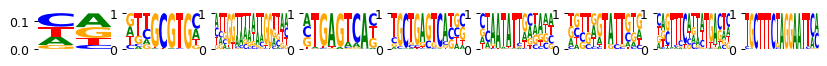

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:29<00:00,  1.97s/it]


Current time: 2024-06-11 01:56:51.150485
	Loss: 161.864 , R2: 0.002
	Training time (model/function): (30.104s / 30.104s)
		per epoch (model/function): (2.150s/ 2.150s)
		per 1k samples: 0.164s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9989849830564137, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 50

### next filter to optimize 50 

FREEZING KERNELS
optimizing feature type mono
next kernels {50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:29<00:00,  1.97s/it]


Current time: 2024-06-11 01:57:35.073773
	Loss: 149.812 , R2: 0.002
	Training time (model/function): (60.169s / 30.065s)
		per epoch (model/function): (4.298s/ 2.148s)
		per 1k samples: 0.163s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9989849830564137, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:30<00:00,  2.03s/it]


Current time: 2024-06-11 01:58:19.980475
	Loss: 144.656 , R2: 0.002
	Training time (model/function): (91.154s / 30.985s)
		per epoch (model/function): (6.511s/ 2.213s)
		per 1k samples: 0.168s
best loss 144.656
last five r2 values, by sequential filter optimization: ['0.002']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9989849830564137, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 100

### next filter to optimize 100 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:29<00:00,  1.94s/it]


Current time: 2024-06-11 01:59:17.114414
	Loss: 148.273 , R2: 0.003
	Training time (model/function): (120.788s / 29.634s)
		per epoch (model/function): (8.628s/ 2.117s)
		per 1k samples: 0.161s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9989849830564137, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:28<00:00,  1.90s/it]


Current time: 2024-06-11 01:59:59.940649
	Loss: 144.479 , R2: 0.003
	Training time (model/function): (149.902s / 29.114s)
		per epoch (model/function): (10.707s/ 2.080s)
		per 1k samples: 0.158s
best loss 144.479
last five r2 values, by sequential filter optimization: ['0.002', '0.003']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9989849830564137, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 150

### next filter to optimize 150 

FREEZING KERNELS
optimizing feature type mono
next kernels {150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:27<00:00,  1.81s/it]


Current time: 2024-06-11 02:00:55.093211
	Loss: 148.243 , R2: 0.003
	Training time (model/function): (177.599s / 27.697s)
		per epoch (model/function): (12.686s/ 1.978s)
		per 1k samples: 0.151s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9989849830564137, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:28<00:00,  1.89s/it]


Current time: 2024-06-11 02:01:37.716295
	Loss: 144.477 , R2: 0.003
	Training time (model/function): (206.482s / 28.883s)
		per epoch (model/function): (14.749s/ 2.063s)
		per 1k samples: 0.157s
best loss 144.477
last five r2 values, by sequential filter optimization: ['0.002', '0.003', '0.003']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9989849830564137, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 200

### next filter to optimize 200 

FREEZING KERNELS
optimizing feature type mono
next kernels {200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:27<00:00,  1.81s/it]


Current time: 2024-06-11 02:02:32.587978
	Loss: 148.234 , R2: 0.003
	Training time (model/function): (234.124s / 27.642s)
		per epoch (model/function): (16.723s/ 1.974s)
		per 1k samples: 0.150s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9989849830564137, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:28<00:00,  1.87s/it]


Current time: 2024-06-11 02:03:14.867494
	Loss: 144.477 , R2: 0.003
	Training time (model/function): (262.784s / 28.660s)
		per epoch (model/function): (18.770s/ 2.047s)
		per 1k samples: 0.156s
best loss 144.477
last five r2 values, by sequential filter optimization: ['0.002', '0.003', '0.003', '0.003']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9989849830564137, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 250

### next filter to optimize 250 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:27<00:00,  1.81s/it]


Current time: 2024-06-11 02:04:09.684965
	Loss: 148.225 , R2: 0.003
	Training time (model/function): (290.461s / 27.677s)
		per epoch (model/function): (20.747s/ 1.977s)
		per 1k samples: 0.150s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9989849830564137, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:28<00:00,  1.88s/it]


Current time: 2024-06-11 02:04:52.063330
	Loss: 144.477 , R2: 0.003
	Training time (model/function): (319.263s / 28.802s)
		per epoch (model/function): (22.805s/ 2.057s)
		per 1k samples: 0.157s
best loss 144.477
last five r2 values, by sequential filter optimization: ['0.002', '0.003', '0.003', '0.003', '0.003']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9989849830564137, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 319.263295173645s
Time per epoch (total): 0.073 s
saving model...
True /home/ilibarra/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/episcanpy/mubind_output/obs5000/pwms/running_time.pkl
/home/ilibarra/workspace/theislab/mubind/data/pbmc/episcanpy/processed_laura_2023_obs5000_var15000.h5ad
pbmc (5000, 14987)
False /home/ilibarra/workspace/theislab/mubind/data/pbmc/episcanpy/mubind_output/obs5000/pwms/model.pt
False /home/ilibarra/worksp

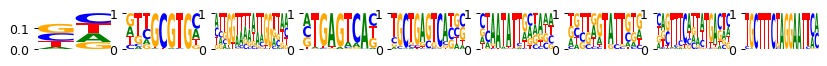

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:28<00:00,  1.90s/it]


Current time: 2024-06-11 02:07:49.487469
	Loss: 161.171 , R2: 0.005
	Training time (model/function): (29.062s / 29.062s)
		per epoch (model/function): (2.076s/ 2.076s)
		per 1k samples: 0.154s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9990302055872455, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 50

### next filter to optimize 50 

FREEZING KERNELS
optimizing feature type mono
next kernels {50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:28<00:00,  1.90s/it]


Current time: 2024-06-11 02:08:24.376656
	Loss: 149.663 , R2: 0.005
	Training time (model/function): (58.200s / 29.138s)
		per epoch (model/function): (4.157s/ 2.081s)
		per 1k samples: 0.154s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9990302055872455, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:29<00:00,  1.98s/it]


Current time: 2024-06-11 02:09:00.503536
	Loss: 144.628 , R2: 0.005
	Training time (model/function): (88.579s / 30.379s)
		per epoch (model/function): (6.327s/ 2.170s)
		per 1k samples: 0.161s
best loss 144.628
last five r2 values, by sequential filter optimization: ['0.005']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9990302055872455, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 100

### next filter to optimize 100 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:28<00:00,  1.90s/it]


Current time: 2024-06-11 02:09:41.071375
	Loss: 148.265 , R2: 0.005
	Training time (model/function): (117.660s / 29.080s)
		per epoch (model/function): (8.404s/ 2.077s)
		per 1k samples: 0.154s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9990302055872455, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:29<00:00,  1.99s/it]


Current time: 2024-06-11 02:10:17.226732
	Loss: 144.475 , R2: 0.005
	Training time (model/function): (148.105s / 30.445s)
		per epoch (model/function): (10.579s/ 2.175s)
		per 1k samples: 0.161s
best loss 144.475
last five r2 values, by sequential filter optimization: ['0.005', '0.005']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9990302055872455, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 150

### next filter to optimize 150 

FREEZING KERNELS
optimizing feature type mono
next kernels {150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:28<00:00,  1.90s/it]


Current time: 2024-06-11 02:10:57.997770
	Loss: 148.239 , R2: 0.005
	Training time (model/function): (177.283s / 29.178s)
		per epoch (model/function): (12.663s/ 2.084s)
		per 1k samples: 0.155s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9990302055872455, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:29<00:00,  1.98s/it]


Current time: 2024-06-11 02:11:34.128359
	Loss: 144.473 , R2: 0.005
	Training time (model/function): (207.662s / 30.380s)
		per epoch (model/function): (14.833s/ 2.170s)
		per 1k samples: 0.161s
best loss 144.473
last five r2 values, by sequential filter optimization: ['0.005', '0.005', '0.005']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9990302055872455, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 200

### next filter to optimize 200 

FREEZING KERNELS
optimizing feature type mono
next kernels {200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:28<00:00,  1.89s/it]


Current time: 2024-06-11 02:12:14.645185
	Loss: 148.230 , R2: 0.005
	Training time (model/function): (236.690s / 29.028s)
		per epoch (model/function): (16.906s/ 2.073s)
		per 1k samples: 0.154s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9990302055872455, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:29<00:00,  1.97s/it]


Current time: 2024-06-11 02:12:50.570477
	Loss: 144.473 , R2: 0.005
	Training time (model/function): (266.869s / 30.179s)
		per epoch (model/function): (19.062s/ 2.156s)
		per 1k samples: 0.160s
best loss 144.473
last five r2 values, by sequential filter optimization: ['0.005', '0.005', '0.005', '0.005']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9990302055872455, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 250

### next filter to optimize 250 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:28<00:00,  1.89s/it]


Current time: 2024-06-11 02:13:31.081917
	Loss: 148.221 , R2: 0.005
	Training time (model/function): (295.899s / 29.030s)
		per epoch (model/function): (21.136s/ 2.074s)
		per 1k samples: 0.154s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9990302055872455, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:29<00:00,  1.97s/it]


Current time: 2024-06-11 02:14:07.004388
	Loss: 144.473 , R2: 0.005
	Training time (model/function): (326.088s / 30.189s)
		per epoch (model/function): (23.292s/ 2.156s)
		per 1k samples: 0.160s
best loss 144.473
last five r2 values, by sequential filter optimization: ['0.005', '0.005', '0.005', '0.005', '0.005']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9990302055872455, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 326.0876479148865s
Time per epoch (total): 0.075 s
saving model...
True /home/ilibarra/workspace/theislab/mubind/data/pbmc/episcanpy/mubind_output/obs5000/pwms/running_time.pkl
/home/ilibarra/workspace/theislab/mubind/data/noack_2022/episcanpy/merged_scATAC_integrated_cicero_faye_chong_obs5000_var15000.h5ad
pbmc (5000, 15000)
ad path not found. Next
/home/ilibarra/workspace/theislab/mubind/data/noack_2022/random/merged_scATAC_integrated_cicero_faye

Feature (chr13:114459120-114459620) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:114685328-114685828) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:114964193-114964693) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:115009708-115010208) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:115130475-115130975) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:116514738-116515238) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:117728059-117728559) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:117880800-117881300) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:117959009-117959509) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:118642642-118643142) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:119735641-119736141) beyond the len

preparing sequences test...
/tmp/tmpitf7ae6q
genome hg19 False
/home/ilibarra/annotations/hg38/genome/hg38.fa
True /home/ilibarra/annotations/hg38/genome/hg38.fa
running bedtools...
['bedtools', 'getfasta', '-fi', '/home/ilibarra/annotations/hg38/genome/hg38.fa', '-bed', '/tmp/tmpitf7ae6q', '-fo', '/tmp/tmpqsyrp27z']
bedtools getfasta -fi /home/ilibarra/annotations/hg38/genome/hg38.fa -bed /tmp/tmpitf7ae6q -fo /tmp/tmpqsyrp27z
(5000, 13194) (5000, 722)
sum of reads 4681185.0
(13194, 5001)
# cells 5000
# peaks 13194
selected (13194, 5000)
(722, 5001)
# cells 5000
# peaks 722
selected (722, 5000)
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1

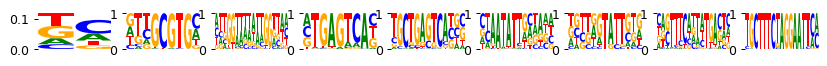

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:23<00:00,  1.54s/it]


Current time: 2024-06-11 02:16:27.680745
	Loss: 162.032 , R2: 0.181
	Training time (model/function): (23.546s / 23.546s)
		per epoch (model/function): (1.682s/ 1.682s)
		per 1k samples: 0.127s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9983915452641877, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 50

### next filter to optimize 50 

FREEZING KERNELS
optimizing feature type mono
next kernels {50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:23<00:00,  1.54s/it]


Current time: 2024-06-11 02:17:04.612496
	Loss: 149.980 , R2: 0.181
	Training time (model/function): (47.167s / 23.621s)
		per epoch (model/function): (3.369s/ 1.687s)
		per 1k samples: 0.128s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9983915452641877, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:24<00:00,  1.62s/it]


Current time: 2024-06-11 02:17:42.883342
	Loss: 144.824 , R2: 0.181
	Training time (model/function): (71.973s / 24.805s)
		per epoch (model/function): (5.141s/ 1.772s)
		per 1k samples: 0.134s
best loss 144.824
last five r2 values, by sequential filter optimization: ['0.181']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9983915452641877, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 100

### next filter to optimize 100 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:23<00:00,  1.54s/it]


Current time: 2024-06-11 02:18:33.337281
	Loss: 148.442 , R2: 0.181
	Training time (model/function): (95.565s / 23.592s)
		per epoch (model/function): (6.826s/ 1.685s)
		per 1k samples: 0.128s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9983915452641877, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:24<00:00,  1.62s/it]


Current time: 2024-06-11 02:19:12.020240
	Loss: 144.648 , R2: 0.181
	Training time (model/function): (120.372s / 24.808s)
		per epoch (model/function): (8.598s/ 1.772s)
		per 1k samples: 0.134s
best loss 144.648
last five r2 values, by sequential filter optimization: ['0.181', '0.181']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9983915452641877, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 150

### next filter to optimize 150 

FREEZING KERNELS
optimizing feature type mono
next kernels {150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:23<00:00,  1.54s/it]


Current time: 2024-06-11 02:20:02.464355
	Loss: 148.412 , R2: 0.181
	Training time (model/function): (143.931s / 23.559s)
		per epoch (model/function): (10.281s/ 1.683s)
		per 1k samples: 0.128s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9983915452641877, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:24<00:00,  1.61s/it]


Current time: 2024-06-11 02:20:40.360343
	Loss: 144.645 , R2: 0.181
	Training time (model/function): (168.598s / 24.668s)
		per epoch (model/function): (12.043s/ 1.762s)
		per 1k samples: 0.134s
best loss 144.645
last five r2 values, by sequential filter optimization: ['0.181', '0.181', '0.181']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9983915452641877, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 200

### next filter to optimize 200 

FREEZING KERNELS
optimizing feature type mono
next kernels {200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:23<00:00,  1.54s/it]


Current time: 2024-06-11 02:21:30.764973
	Loss: 148.412 , R2: 0.182
	Training time (model/function): (192.151s / 23.553s)
		per epoch (model/function): (13.725s/ 1.682s)
		per 1k samples: 0.128s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9983915452641877, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:24<00:00,  1.60s/it]


Current time: 2024-06-11 02:22:08.708447
	Loss: 144.645 , R2: 0.182
	Training time (model/function): (216.696s / 24.545s)
		per epoch (model/function): (15.478s/ 1.753s)
		per 1k samples: 0.133s
best loss 144.645
last five r2 values, by sequential filter optimization: ['0.181', '0.181', '0.181', '0.182']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9983915452641877, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 250

### next filter to optimize 250 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:22<00:00,  1.53s/it]


Current time: 2024-06-11 02:22:59.011667
	Loss: 148.409 , R2: 0.182
	Training time (model/function): (240.156s / 23.459s)
		per epoch (model/function): (17.154s/ 1.676s)
		per 1k samples: 0.127s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9983915452641877, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:24<00:00,  1.60s/it]


Current time: 2024-06-11 02:23:37.048323
	Loss: 144.645 , R2: 0.182
	Training time (model/function): (264.725s / 24.570s)
		per epoch (model/function): (18.909s/ 1.755s)
		per 1k samples: 0.133s
best loss 144.645
last five r2 values, by sequential filter optimization: ['0.181', '0.181', '0.181', '0.182', '0.182']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9983915452641877, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 264.7250533103943s
Time per epoch (total): 0.061 s
saving model...
True /home/ilibarra/workspace/theislab/mubind/data/noack_2022/random/mubind_output/obs5000/pwms/running_time.pkl
/home/ilibarra/workspace/theislab/mubind/data/noack_2022/random/merged_scATAC_integrated_cicero_faye_chong_obs10000_var30000.h5ad
pbmc (5877, 30000)
False /home/ilibarra/workspace/theislab/mubind/data/noack_2022/random/mubind_output/obs10000/pwms/model.pt
False /home/ilib

Feature (chr13:114459120-114459620) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:114584583-114585083) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:114685328-114685828) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:115007667-115008167) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:115021373-115021873) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:115037279-115037779) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:115100428-115100928) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:115257728-115258228) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:116062493-116062993) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:116086862-116087362) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr13:116215051-116215551) beyond the len

preparing sequences test...
/tmp/tmp3ms8z6kq
genome hg19 False
/home/ilibarra/annotations/hg38/genome/hg38.fa
True /home/ilibarra/annotations/hg38/genome/hg38.fa
running bedtools...
['bedtools', 'getfasta', '-fi', '/home/ilibarra/annotations/hg38/genome/hg38.fa', '-bed', '/tmp/tmp3ms8z6kq', '-fo', '/tmp/tmpt9yk9mvy']
bedtools getfasta -fi /home/ilibarra/annotations/hg38/genome/hg38.fa -bed /tmp/tmp3ms8z6kq -fo /tmp/tmpt9yk9mvy
(5877, 26375) (5877, 1463)
sum of reads 10966881.0
(26375, 5878)
# cells 5877
# peaks 26375
selected (26375, 5877)
(1463, 5878)
# cells 5877
# peaks 1463
selected (1463, 5877)
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 

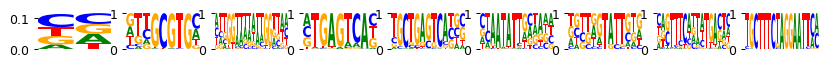

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:50<00:00,  3.39s/it]


Current time: 2024-06-11 02:27:16.045486
	Loss: 153.423 , R2: 0.179
	Training time (model/function): (52.096s / 52.096s)
		per epoch (model/function): (3.721s/ 3.721s)
		per 1k samples: 0.141s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9954879834424702, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 50

### next filter to optimize 50 

FREEZING KERNELS
optimizing feature type mono
next kernels {50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:50<00:00,  3.37s/it]


Current time: 2024-06-11 02:28:36.600739
	Loss: 148.651 , R2: 0.179
	Training time (model/function): (103.896s / 51.799s)
		per epoch (model/function): (7.421s/ 3.700s)
		per 1k samples: 0.140s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9954879834424702, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:53<00:00,  3.57s/it]


Current time: 2024-06-11 02:29:59.991517
	Loss: 144.655 , R2: 0.179
	Training time (model/function): (158.652s / 54.756s)
		per epoch (model/function): (11.332s/ 3.911s)
		per 1k samples: 0.148s
best loss 144.655
last five r2 values, by sequential filter optimization: ['0.179']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9954879834424702, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 100

### next filter to optimize 100 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:50<00:00,  3.37s/it]


Current time: 2024-06-11 02:31:49.342240
	Loss: 148.422 , R2: 0.179
	Training time (model/function): (210.436s / 51.785s)
		per epoch (model/function): (15.031s/ 3.699s)
		per 1k samples: 0.140s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9954879834424702, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:53<00:00,  3.56s/it]


Current time: 2024-06-11 02:33:12.911295
	Loss: 144.645 , R2: 0.179
	Training time (model/function): (264.988s / 54.552s)
		per epoch (model/function): (18.928s/ 3.897s)
		per 1k samples: 0.148s
best loss 144.645
last five r2 values, by sequential filter optimization: ['0.179', '0.179']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9954879834424702, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 150

### next filter to optimize 150 

FREEZING KERNELS
optimizing feature type mono
next kernels {150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:50<00:00,  3.35s/it]


Current time: 2024-06-11 02:35:02.501921
	Loss: 148.481 , R2: 0.179
	Training time (model/function): (316.487s / 51.499s)
		per epoch (model/function): (22.606s/ 3.678s)
		per 1k samples: 0.139s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9954879834424702, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:53<00:00,  3.55s/it]


Current time: 2024-06-11 02:36:25.775164
	Loss: 144.645 , R2: 0.179
	Training time (model/function): (370.914s / 54.427s)
		per epoch (model/function): (26.494s/ 3.888s)
		per 1k samples: 0.147s
best loss 144.645
last five r2 values, by sequential filter optimization: ['0.179', '0.179', '0.179']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9954879834424702, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 200

### next filter to optimize 200 

FREEZING KERNELS
optimizing feature type mono
next kernels {200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:50<00:00,  3.35s/it]


Current time: 2024-06-11 02:38:15.236603
	Loss: 148.483 , R2: 0.179
	Training time (model/function): (422.410s / 51.495s)
		per epoch (model/function): (30.172s/ 3.678s)
		per 1k samples: 0.139s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9954879834424702, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:53<00:00,  3.54s/it]


Current time: 2024-06-11 02:39:38.835616
	Loss: 144.645 , R2: 0.179
	Training time (model/function): (476.630s / 54.220s)
		per epoch (model/function): (34.045s/ 3.873s)
		per 1k samples: 0.147s
best loss 144.645
last five r2 values, by sequential filter optimization: ['0.179', '0.179', '0.179', '0.179']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9954879834424702, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 250

### next filter to optimize 250 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:50<00:00,  3.35s/it]


Current time: 2024-06-11 02:41:28.292859
	Loss: 148.499 , R2: 0.179
	Training time (model/function): (528.110s / 51.480s)
		per epoch (model/function): (37.722s/ 3.677s)
		per 1k samples: 0.139s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9954879834424702, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:53<00:00,  3.54s/it]


Current time: 2024-06-11 02:42:51.480490
	Loss: 144.645 , R2: 0.179
	Training time (model/function): (582.322s / 54.212s)
		per epoch (model/function): (41.594s/ 3.872s)
		per 1k samples: 0.147s
best loss 144.645
last five r2 values, by sequential filter optimization: ['0.179', '0.179', '0.179', '0.179', '0.179']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9954879834424702, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 582.3220100402832s
Time per epoch (total): 0.134 s
saving model...
True /home/ilibarra/workspace/theislab/mubind/data/noack_2022/random/mubind_output/obs10000/pwms/running_time.pkl
/home/ilibarra/workspace/theislab/mubind/data/pbmc/random/processed_laura_2023_obs10000_var30000.h5ad
pbmc (10000, 29982)
False /home/ilibarra/workspace/theislab/mubind/data/pbmc/random/mubind_output/obs10000/pwms/model.pt
False /home/ilibarra/workspace/theislab/mubind/d

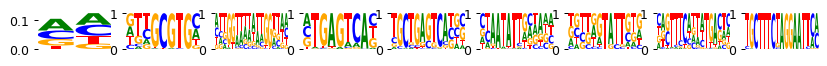

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:32<00:00,  6.17s/it]


Current time: 2024-06-11 02:50:02.917696
	Loss: 153.279 , R2: 0.326
	Training time (model/function): (94.832s / 94.832s)
		per epoch (model/function): (6.774s/ 6.774s)
		per 1k samples: 0.251s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9768307364377565, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 50

### next filter to optimize 50 

FREEZING KERNELS
optimizing feature type mono
next kernels {50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:32<00:00,  6.17s/it]


Current time: 2024-06-11 02:52:00.492299
	Loss: 148.638 , R2: 0.326
	Training time (model/function): (189.701s / 94.869s)
		per epoch (model/function): (13.550s/ 6.776s)
		per 1k samples: 0.251s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9768307364377565, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


  0%|                                                                                                                                                | 0/15 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 5.49 GiB. GPU 

: 

In [18]:
res = []
import numpy as np
import pickle
n_epochs_intercept = 15
n_epochs_kernel = 15
overwrite = False
overwrite_train = False
log_each=75
n_unfreeze_kernels=50

n_missing = 0

for ri, r in queries.sort_values('n_obs').iterrows():
# for k in path_by_dataset:
#     for ad_path in glob.glob(path_by_dataset[k]):
    # if not '_obs100_' in ad_path: #  and not '_obs200_' in ad_path: #  or not '/random/' in ad_path:
    #     continue

    ad_path = r['path']

    n_cells = ad_path.split('_')[-2]
    print(ad_path)

    # assert False
    # print('reading anndata', ad_path)

    # print(ad_path)
    # continue

    adata = sc.read_h5ad(ad_path)
    print(k, adata.shape)
    # if neighbors are not present in the file, we have to include them
    if not 'neighbors' in adata.uns:
        if 'int' in str(adata.X.dtype):
            adata.X = adata.X.astype(float)
        sc.pp.neighbors(adata, method='rapids')

    scbasset_split_file = os.path.join(os.path.dirname(ad_path), 'scbasset_input', n_cells, 'splits.h5')
    scbasset_ad_path = os.path.join(os.path.dirname(ad_path), 'scbasset_input', n_cells, 'ad.h5ad')


    if not os.path.exists(scbasset_ad_path):
        print('ad path not found. Next')
        continue

    mubind_outdir = os.path.join(os.path.dirname(ad_path), 'mubind_output', n_cells)
    if not os.path.exists(mubind_outdir):
        os.makedirs(mubind_outdir)
    
    for use_pwms, lab in zip([True, False], ['pwms', 'denovo']):
        if lab != 'pwms':
            continue
        
        next_outdir = os.path.join(mubind_outdir, lab)
        if not os.path.exists(next_outdir):
            os.makedirs(next_outdir)
        
        model_path = os.path.join(next_outdir, 'model.pt')
        print(os.path.exists(model_path), model_path)

        model_path_logdyn_true = model_path.replace('.pt', '_1.pt')

        print(os.path.exists(model_path_logdyn_true), model_path_logdyn_true)

        # assert False
        if not os.path.exists(model_path_logdyn_true):
            n_missing += 1
    
        if not os.path.exists(model_path_logdyn_true) or overwrite:
            adata_train, train, test = prepare_mubind_input(scbasset_ad_path,
                                                            adata,
                                                            k,
                                                            scbasset_split_file)

            model_by_logdynamic = {}
            n_filters = 5 if lab == 'denovo' else 288
            opt_kernel_shift=[0, 0] + [0] * (n_filters)
            opt_kernel_length=[0, 0] + [0] * (n_filters)
            kernels=[0] + [2] + [20] * (n_filters)

            w = [10 for r in range(n_filters)]
            epochs = [n_epochs_intercept] + [n_epochs_kernel] * (n_filters + 1)
            print(epochs)
            # skip_kernels=range(5, 500) do not skip kernels
            opt_kernel_shift=[0, 0] + [0] * (n_filters)

            for optimize_log_dynamic in [False,]: #  True]: #  True]:

                # save model
                next_model_path = model_path.replace('.pt', '_%i.pt' % optimize_log_dynamic)
                print(k, next_model_path)

                if not os.path.exists(next_model_path) or overwrite_train:
                    print('')
                    print('optimize log dynamics', optimize_log_dynamic)
                    warnings.filterwarnings("ignore")

                    criterion = mb.tl.PoissonLoss()
                    # w = [r.shape[1] for r in pwms]

                    if use_pwms:
                        pwms = mb.datasets.archetypes()
                        w = [r.shape[1] for r in pwms]

                    model = mb.models.Mubind.make_model(train,
                                                        n_filters,
                                                        criterion,
                                                        kernels=[0, 2] + w,
                                                        # use_dinuc=True, dinuc_mode='full',
                                                        optimize_sym_weight=False,
                                                        optimize_exp_barrier=True,
                                                        optimize_prob_act=True,
                                                        optimize_log_dynamic=optimize_log_dynamic,
                                                        use_dinuc=False,
                                                        device=device,
                                                        log_each=log_each,
                                                        p_dropout=None, # 0.8,
                                                        adata=adata_train if optimize_log_dynamic else None,
                                                        prepare_knn=optimize_log_dynamic,
                                                        dinuc_mode=None).cuda()
                    

                    if use_pwms:
                        # initialize the reduce kernels
                        for i, mono_best in enumerate(pwms):
                            mono_best = mono_best.to_numpy()
                            if mono_best.shape[-1] == 0:
                                continue
                            # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
                            # print(model.binding_modes.conv_mono[i + 1].weight.device)
                            new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
                            # print(i, i + 1)
                            model.binding_modes.conv_mono[i + 2].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float))
                            # print(model.binding_modes.conv_mono[i + 1].weight.device)
                        # move the model a final time to the GPU
                        model = model.to(device)

                    mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
                    mb.pl.logo(model,
                            title=False,
                            xticks=False,
                            rowspan_dinuc=0,
                            rowspan_mono=1,
                            n_rows=5,
                            n_cols=12,
                            stop_at=10   ) # n_cols=len(reduced_groups))
                        
                    mb.pl.set_rcParams({'figure.figsize': [20, 5], 'figure.dpi': 100})

                    # mb.pl.conv(model, n_cols=2)
                    import torch.nn as tnn

                    if optimize_log_dynamic:
                        model.graph_module.conn_sparse = torch.tensor(adata[adata_train.obs_names,:].obsp['connectivities'].A).to_sparse().requires_grad_(True).cuda()
                        model.graph_module.log_dynamic = tnn.Parameter(torch.rand(model.graph_module.conn_sparse.indices().shape[1])) # .cuda()
                        model = model.cuda()
                        model.graph_module.log_dynamic.shape


                    import datetime
                    t1 = datetime.datetime.now()
                    model, best_loss = model.optimize_iterative(train,
                                                                n_epochs=epochs,
                                                                show_logo=False,
                                                                use_mono=True,
                                                                use_dinuc=False,
                                                                dinuc_mode='local',
                                                                opt_kernel_shift=opt_kernel_shift,
                                                                opt_kernel_length=opt_kernel_length,
                                                                opt_one_step=True,
                                                                shift_max=1,
                                                                shift_step=1,
                                                                optimiser=topti.Adam,
                                                                n_batches=1,
                                                                n_rounds=2,
                                                                num_epochs_shift_factor=1,
                                                                r2_per_epoch=True,
                                                                kernels=kernels,
                                                                n_unfreeze_kernels=n_unfreeze_kernels,
                                                                skip_kernels=None, # skip_kernels,
                                                                exp_max=8,
                                                                early_stopping=250,
                                                                log_each=log_each,
                                                                w=20,
                                                                max_w=20) #  target_dim=train.dataset.signal.shape[1])

                    t2 = datetime.datetime.now()

                    torch.save(model, next_model_path)
                    model_by_logdynamic[optimize_log_dynamic] = model

                    print('saving model...')
                    outpath_time = os.path.join(next_outdir, 'running_time.pkl')
                    time_diff = (t2 - t1)
                    pickle.dump(time_diff, open(outpath_time, 'wb'))
                    print(os.path.exists(outpath_time), outpath_time)
                    
                else:
                    model = torch.load(next_model_path)

                roc_auc_train, roc_auc_test = utils.get_auroc(model, train), utils.get_auroc(model, test)
                auprc_train, auprc_test = utils.get_auprc(model, train), utils.get_auprc(model, test)
                res.append([k, optimize_log_dynamic, 'train', 'roc_auc', roc_auc_train])
                res.append([k, optimize_log_dynamic, 'test', 'roc_auc', roc_auc_test])
                res.append([k, optimize_log_dynamic, 'train', 'pr_auc', auprc_train])
                res.append([k, optimize_log_dynamic, 'test', 'pr_auc', auprc_test])
            
            import pandas as pd
            df = pd.DataFrame(res, columns=['dataset', 'log_dynamic', 'group', 'metric', 'value'])
            df.to_csv(model_path.replace('.pt', '.csv'))

print(n_missing)

In [ ]:
import anndata
anndata.__version__

'0.10.7'